# Introduction

Predict Future Sales: The final project for "How to win a data science competition" Coursera course, part 2 of the advanced machine learning specialization. The goal is to predict the monthly sales of items in each shop for the month of Novemeber. There are 33 months of daily item-shop data given in the training dataset.

https://www.kaggle.com/c/competitive-data-science-predict-future-sales/overview

In [1244]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import gc
sns.set(style="darkgrid")


import os
for dirname, _, filenames in os.walk('data'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

data\items.csv
data\item_categories.csv
data\sales_train.csv
data\sample_submission.csv
data\shops.csv
data\test.csv


# Load Data

In [1245]:


# load data
items=pd.read_csv("data/items.csv")
shops=pd.read_csv("data/shops.csv")
item_categories=pd.read_csv("data/item_categories.csv")
train=pd.read_csv("data/sales_train.csv")
test=pd.read_csv("data/test.csv")

# 1. Data Cleaning

We'll remove outliers, clean up some of the raw data and add some new variables to it.

# Remove outliers

<AxesSubplot:xlabel='item_price'>

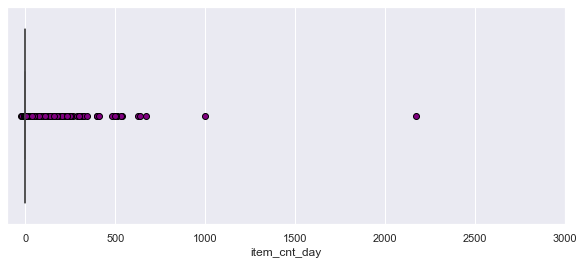

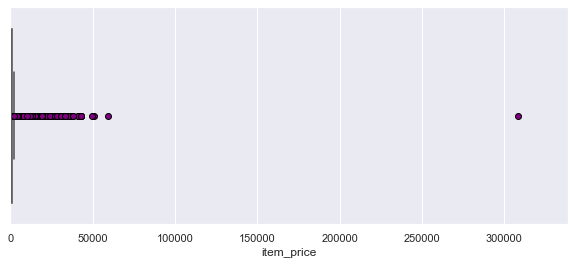

In [1246]:
plt.figure(figsize=(10,4))
plt.xlim(-100, 3000)
flierprops = dict(marker='o', markerfacecolor='purple', markersize=6,
                  linestyle='none', markeredgecolor='black')
sns.boxplot(x=train.item_cnt_day, flierprops=flierprops)

plt.figure(figsize=(10,4))
plt.xlim(train.item_price.min(), train.item_price.max()*1.1)
sns.boxplot(x=train.item_price, flierprops=flierprops)

We'll remove the obvious outliers in the dataset - the items that sold more than 1000 in one day and the item with price greater than 300,000.

In [1247]:
#lowest prices
# train.sort_values(['item_price']).head(n=10)

In [1248]:
# train.sort_values(['item_price']).tail(n=10)

In [1249]:
# train.sort_values(['item_cnt_day']).head(n=10)

In [1250]:
# train.sort_values(['item_cnt_day']).tail(n=10)

# Large Price, Item Count Outlier

This item id only has 1 record. It will be removed from the dataset.

In [1251]:
# train[train['item_id'] == 6066]

In [1252]:
train.drop(1163158,axis=0,inplace=True)
train.reset_index(drop=True,inplace=True)

# Negative Prices

The negative price will be replaced by the median value for the item id, shop id, and date block number.

In [1253]:
# train[train['item_id'] == 2973].sort_values('item_price').head(n=5)

In [1254]:
# train.loc[484683,'item_price'] = train[(train['item_id'] == 2973) \
#                                                & (train['shop_id'] == 32) \
#                                                & (train['date_block_num'] == 4)]['item_price'].median()

# High Item Count Day Outlier

Replace with the median price and item count for item id, shop id, and date block number.

In [1255]:
# train[(train.item_id == 11373)&(train.date_block_num==33)].sort_values('item_cnt_day').tail()

In [1256]:
train.loc[2909817,'item_price'] = train[(train['item_id'] == 11373) \
                                               & (train['shop_id'] == 12) \
                                               & (train['date_block_num'] == 33)]['item_price'].median()

train.loc[2909817,'item_cnt_day'] = train[(train['item_id'] == 11373) \
                                               & (train['shop_id'] == 12) \
                                               & (train['date_block_num'] == 33)]['item_cnt_day'].median()

Remove any rows from train where item price is negative - these could be refunds. Also make zero and item_cnt_day values less than one, to remove negative values.

In [1257]:
train.loc[484683,'item_price'] = train[(train['item_id'] == 2973) \
                                               & (train['shop_id'] == 32) \
                                               & (train['date_block_num'] == 4)]['item_price'].median()

In [1258]:
train = train[train.item_price > 0].reset_index(drop = True)
train.loc[train.item_cnt_day < 1, "item_cnt_day"] = 0

# Cleaning Shop Data

Several of the shops look like duplicates of each other. This could be down to shops re-opening or possibly moving store location on the same street or shopping centre.

In [1259]:
# Якутск Орджоникидзе, 56
train.loc[train.shop_id == 0, 'shop_id'] = 57
test.loc[test.shop_id == 0, 'shop_id'] = 57
# Якутск ТЦ "Центральный"
train.loc[train.shop_id == 1, 'shop_id'] = 58
test.loc[test.shop_id == 1, 'shop_id'] = 58
# Жуковский ул. Чкалова 39м²
train.loc[train.shop_id == 10, 'shop_id'] = 11
test.loc[test.shop_id == 10, 'shop_id'] = 11

Clean up some shop names and add 'city' and 'category' to shops df.

In [1260]:
shops.loc[ shops.shop_name == 'Сергиев Посад ТЦ "7Я"',"shop_name" ] = 'СергиевПосад ТЦ "7Я"'
shops["city"] = shops.shop_name.str.split(" ").map( lambda x: x[0] )
shops.loc[shops.city == "!Якутск", "city"] = "Якутск"

Only keep shop category if there are 5 or more shops of that category, the rest are grouped as "other".

In [1261]:
shops["category"] = shops.shop_name.apply(lambda x: 'мтрц' if 'мтрц' in x.lower()
                                               else 'трц' if 'трц' in x else 'трк' if 'трк' in x.lower()
                                               else 'тц' if 'тц' in x.lower()
                                               else 'тк' if 'тк' in x.lower()
                                               else 'NA')

In [1262]:
from sklearn.preprocessing import LabelEncoder
shops["shop_category"] = LabelEncoder().fit_transform( shops.category )
shops["shop_city"] = LabelEncoder().fit_transform( shops.city )
shops = shops[["shop_id", "shop_category", "shop_city"]]

# Cleaning Item Category Data

In [1263]:

l_cat = list(item_categories.item_category_name)

for ind in range(0,1):

    l_cat[ind] = 'PC Headsets / Headphones'

for ind in range(1,8):

    l_cat[ind] = 'Access'

l_cat[8] = 'Tickets (figure)'

l_cat[9] = 'Delivery of goods'

for ind in range(10,18):

    l_cat[ind] = 'Consoles'

for ind in range(18,25):

    l_cat[ind] = 'Consoles Games'

l_cat[25] = 'Accessories for games'

for ind in range(26,28):

    l_cat[ind] = 'phone games'

for ind in range(28,32):

    l_cat[ind] = 'CD games'

for ind in range(32,37):

    l_cat[ind] = 'Card'

for ind in range(37,43):

    l_cat[ind] = 'Movie'

for ind in range(43,55):

    l_cat[ind] = 'Books'

for ind in range(55,61):

    l_cat[ind] = 'Music'

for ind in range(61,73):

    l_cat[ind] = 'Gifts'

for ind in range(73,79):

    l_cat[ind] = 'Soft'

for ind in range(79,81):

    l_cat[ind] = 'Office'

for ind in range(81,83):

    l_cat[ind] = 'Clean'

l_cat[83] = 'Elements of a food'


item_categories['super_item_category'] = l_cat

map_super_item_category_id = {name:i for i,name in enumerate(item_categories.super_item_category.unique())}

item_categories['super_item_category'] = LabelEncoder().fit_transform(item_categories['super_item_category'])



In [1264]:
item_categories["type_code"] = item_categories.item_category_name.apply( lambda x: x.split(" ")[0] ).astype(str)
item_categories.loc[ (item_categories.type_code == "Игровые")| (item_categories.type_code == "Аксессуары"), "category" ] = "Игры"

In [1265]:
type_code_len = item_categories.groupby("type_code")["type_code"].transform(len)
item_categories.loc[(type_code_len > 5),'type_code'] = 'etc'

In [1266]:
item_categories.type_code = LabelEncoder().fit_transform(item_categories.type_code)
item_categories["split"] = item_categories.item_category_name.apply(lambda x: x.split("-"))
item_categories["subtype"] = item_categories.split.apply(lambda x: x[1].strip() if len(x) > 1 else x[0].strip())
item_categories["subtype_code"] = LabelEncoder().fit_transform( item_categories["subtype"] )
item_categories = item_categories[["item_category_id", "super_item_category","subtype_code", "type_code"]]

# Cleaning Item Data

In [1267]:
import re
def name_correction(x):
    x = x.lower() # all letters lower case
    x = x.partition('[')[0] # partition by square brackets
    x = x.partition('(')[0] # partition by curly brackets
    x = re.sub('[^A-Za-z0-9А-Яа-я]+', ' ', x) # remove special characters
    x = x.replace('  ', ' ') # replace double spaces with single spaces
    x = x.strip() # remove leading and trailing white space
    return x

Clean item names.

In [1268]:
# split item names by first bracket
items["name1"], items["name2"] = items.item_name.str.split("[", 1).str
items["name1"], items["name3"] = items.item_name.str.split("(", 1).str

# replace special characters and turn to lower case
items["name2"] = items.name2.str.replace('[^A-Za-z0-9А-Яа-я]+', " ").str.lower()
items["name3"] = items.name3.str.replace('[^A-Za-z0-9А-Яа-я]+', " ").str.lower()

# fill nulls with '0'
items = items.fillna('0')

items["item_name"] = items["item_name"].apply(lambda x: name_correction(x))

# return all characters except the last if name 2 is not "0" - the closing bracket
items.name2 = items.name2.apply( lambda x: x[:-1] if x !="0" else "0")

<ipython-input-1268-9f90f020d8b8>:2: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  items["name1"], items["name2"] = items.item_name.str.split("[", 1).str
<ipython-input-1268-9f90f020d8b8>:3: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  items["name1"], items["name3"] = items.item_name.str.split("(", 1).str


Clean item type

In [1269]:
items["type"] = items.name2.apply(lambda x: x[0:8] if x.split(" ")[0] == "xbox" else x.split(" ")[0] )
items.loc[(items.type == "x360") | (items.type == "xbox360") | (items.type == "xbox 360") ,"type"] = "xbox 360"
items.loc[ items.type == "", "type"] = "mac"
items.type = items.type.apply( lambda x: x.replace(" ", "") )
items.loc[ (items.type == 'pc' )| (items.type == 'pс') | (items.type == "pc"), "type" ] = "pc"
items.loc[ items.type == 'рs3' , "type"] = "ps3"

In [1270]:
name2_len = items.groupby("name2")["item_id"].transform(lambda x: x.nunique())
items['name2'] = items.name2
items.loc[(name2_len.values<5),'name2'] = 'other'

In [1271]:
items.name2 = LabelEncoder().fit_transform(items.name2)
items.name3 = LabelEncoder().fit_transform(items.name3)

# Hash Vector (Item Name) Features

In [ ]:
from sklearn import feature_extraction

items['item_name'] = items['item_name'].apply(lambda x: re.sub('[^a-zA-Z0-9А-Яа-я \n\.]',' ',x).lower())

# High Frequency Grams

def create_hashvec_groupby(offset=0,lag=1):
    
    result = []
    for block in range(12,34+1):
        assert offset<lag
        data = train[(train.date_block_num<block-offset)&(train.date_block_num>=block-lag)].copy()

        feature_count = 10 
        hashvec = feature_extraction.text.HashingVectorizer(n_features=feature_count) 
        data = data[['item_id']].merge(items[['item_id','item_name']],on='item_id') 
        hashvec.fit(data['item_name'].str.lower()) 
  
        gb_hash_vec = data.drop_duplicates().copy()

        txt_feature_mat = hashvec.transform(gb_hash_vec['item_name'].str.lower()).toarray() 
        
        for i in range(txt_feature_mat.shape[1]): 
            feature_name = 'item_name_hashvec_' + str(i) 
            gb_hash_vec[feature_name] = txt_feature_mat[:,i].copy()
            
        gb_hash_vec.drop(['item_name'],axis=1,inplace=True)
        gb_hash_vec['date_block_num'] = block
        
        result+=[gb_hash_vec]
        
    result = pd.concat(result,axis=0).drop_duplicates()
    return result
        
hashvec_result = create_hashvec_groupby(offset=0,lag=6)

In [1287]:
items.drop(["item_name", "name1",'type'],axis = 1, inplace= True)
items.tail()

,item_id,item_category_id,name2,name3
22165,22165,31,21,42
22166,22166,54,53,42
22167,22167,49,1,19
22168,22168,62,1,42
22169,22169,69,1,1180


# Preprocessing

Create a grid df with every combination of month, shop and item in order of increasing month. Item_cnt_day is summed into an item_cnt_month.

In [1288]:
import datetime
def convert_date(x):
    try:
        x = datetime.datetime.strptime(x,'%d.%m.%Y')
    except Exception as e:
        print(e)
        x = np.nan
    return x


train['date'] = train['date'].apply(lambda x: convert_date(x))
train['weekday'] = train.date.dt.weekday

In [1289]:
# add revenue to train df
train["revenue"] = train["item_cnt_day"] * train["item_price"]

In [1290]:
# For every month we create a grid from all shops/items combinations from that month
from itertools import product
grid = []

for block_num in train['date_block_num'].unique():

    cur_shops = train[train['date_block_num']==block_num]['shop_id'].unique()

    cur_items = train[train['date_block_num']==block_num]['item_id'].unique()

    grid.append(np.array(list(product(*[[block_num], cur_shops, cur_items])),dtype='int16'))

index_cols = ['date_block_num', 'shop_id', 'item_id']

grid = pd.DataFrame(np.vstack(grid), columns = index_cols,dtype=np.int32)

grid["date_block_num"] = grid["date_block_num"].astype(np.int8)
grid["shop_id"] = grid["shop_id"].astype(np.int8)
grid["item_id"] = grid["item_id"].astype(np.int16)
grid.sort_values( index_cols, inplace = True )

In [1291]:
gb_cnt = train.groupby(index_cols,as_index=False).agg({'item_cnt_day':'sum'}) \
                                                       .rename(columns={'item_cnt_day':'item_cnt_month'})
grid = pd.merge( grid, gb_cnt, on = index_cols, how = "left" )
grid["item_cnt_month"] = grid["item_cnt_month"].fillna(0).astype(np.float16)

In [1292]:
test["date_block_num"] = 34
test["date_block_num"] = test["date_block_num"].astype(np.int8)
test["shop_id"] = test.shop_id.astype(np.int8)
test["item_id"] = test.item_id.astype(np.int16)

In [1293]:
import time
ts = time.time()

grid = pd.concat([grid, test.drop(["ID"],axis = 1)], ignore_index=True, sort=False, keys=index_cols)
grid.fillna( 0, inplace = True )
time.time() - ts

0.052861690521240234

In [1294]:
ts = time.time()
train = pd.merge( train, shops, on = ["shop_id"], how = "left" )
train = pd.merge(train, items, on = ["item_id"], how = "left")
train = pd.merge( train, item_categories, on = ["item_category_id"], how = "left" )


grid = pd.merge( grid, shops, on = ["shop_id"], how = "left" )
grid = pd.merge(grid, items, on = ["item_id"], how = "left")
grid = pd.merge( grid, item_categories, on = ["item_category_id"], how = "left" )
grid["shop_city"] = grid["shop_city"].astype(np.int8)
grid["shop_category"] = grid["shop_category"].astype(np.int8)
grid["item_category_id"] = grid["item_category_id"].astype(np.int8)
grid["subtype_code"] = grid["subtype_code"].astype(np.int8)
grid["name2"] = grid["name2"].astype(np.int8)
grid["name3"] = grid["name3"].astype(np.int16)
grid["type_code"] = grid["type_code"].astype(np.int8)
time.time() - ts

4.265120029449463

# Time Based Groupbys

This function is used to create group by aggregates on a fuzzy window time frame.

In [1295]:
def time_base_groupby(df,gb_cols,col,name,func,offset=0,lag=1):
    
    result = []
    for block in range(0,34+1):
        assert offset<lag
        data = df[(df.date_block_num<block-offset)&(df.date_block_num>=block-lag)].copy()
        
        gb = data.groupby(gb_cols,as_index=False).agg({col:func}) \
                                               .rename(columns={col:name}) \
                                               .drop_duplicates() 
        gb['date_block_num'] = block
        result+=[gb]

    result = pd.concat(result,axis=0).drop_duplicates()
    return result

In [1296]:
grid["month"] = grid["date_block_num"] % 12
days = pd.Series([31,28,31,30,31,30,31,31,30,31,30,31])
grid["days"] = grid["month"].map(days).astype(np.int8)

In [1297]:
#drop later
grid['item_cnt_month_scale'] = grid['item_cnt_month']/1000

# Hash Vectors (See Above)

In [1298]:
grid = grid.merge(hashvec_result,on=['item_id','date_block_num'],how='left')

# Item Count (Shop, Item)

In [1301]:
time_lag_params = [
    
                      #count 1 mo ago, null if missing
                      dict(df=grid,
                      gb_cols=['shop_id','item_id'],
                      col='item_cnt_month',
                      name='item_cnt_{shop,item}_lag_1',
                      func='mean',
                      offset=0,
                      lag=1),
    
                      #count 2 mo ago, null if missing
                      dict(df=grid,
                      gb_cols=['shop_id','item_id'],
                      col='item_cnt_month',
                      name='item_cnt_{shop,item}_lag_2',
                      func='mean',
                      offset=1,
                      lag=2),
    
                      #count 3 mo ago, null if missing
                      dict(df=grid,
                      gb_cols=['shop_id','item_id'],
                      col='item_cnt_month',
                      name='item_cnt_{shop,item}_lag_3',
                      func='mean',
                      offset=2,
                      lag=3),
    
    
                      #how many non-zero sale days were there in the last 1 mo
                      dict(df=train,
                      gb_cols=['shop_id','item_id'],
                      col='date_block_num',
                      name='item_cnt_{shop,item}_nonzero_1',
                      func= 'count',
                      offset=0,
                      lag=1),
    
    
                      #scaled count in last 4mo
                      dict(df=grid,
                      gb_cols=['shop_id','item_id'],
                      col='item_cnt_month',
                      name='item_cnt_{shop,item}_50p_1_4',
                      func='median',
                      offset=0,
                      lag=4),
    
    
                      #how many non-zero sale days were there in the last 4 mo
                      dict(df=train,
                      gb_cols=['shop_id','item_id'],
                      col='date_block_num',
                      name='item_cnt_{shop,item}_nonzero_1_4',
                      func= 'count',
                      offset=0,
                      lag=4),
    
    
                      #count 3 mo ago, null if missing
                      dict(df=grid,
                      gb_cols=['shop_id','item_id'],
                      col='item_cnt_month_scale',
                      name='item_cnt_{shop,item}_sum_1_3',
                      func='sum',
                      offset=0,
                      lag=3),
    
                      dict(df=grid,
                      gb_cols=['shop_id','item_id'],
                      col='item_cnt_month_scale',
                      name='item_cnt_{shop,item}_sum_3_6',
                      func='sum',
                      offset=3,
                      lag=6),
    
                      dict(df=grid,
                      gb_cols=['shop_id','item_id'],
                      col='item_cnt_month_scale',
                      name='item_cnt_{shop,item}_sum_6_9',
                      func='sum',
                      offset=6,
                      lag=9),
    
                      dict(df=grid,
                      gb_cols=['shop_id','item_id'],
                      col='item_cnt_month_scale',
                      name='item_cnt_{shop,item}_sum_9_12',
                      func='sum',
                      offset=9,
                      lag=12),

                    ]

grid.drop(map(lambda x: x['name'],filter(lambda x: x['name'] in grid.columns,time_lag_params)),axis=1,inplace=True)            
    
results=list(map(lambda x:time_base_groupby(**x),time_lag_params))

for data,params in zip(results,time_lag_params):
    grid = grid.merge(data,on=['shop_id','item_id','date_block_num'],how='left')

    
del time_lag_params
gc.collect()

239675

# DateBlock

In [1302]:
time_lag_params=[
                      dict(df=grid,
                      gb_cols=['date_block_num'],
                      col='item_cnt_month',
                      name='item_cnt_{dateblock}_avg_1',
                      func='mean',
                      offset=0,
                      lag=1),
]


grid.drop(map(lambda x: x['name'],filter(lambda x: x['name'] in grid.columns,time_lag_params)),axis=1,inplace=True)            
    

results=list(map(lambda x:time_base_groupby(**x),time_lag_params))

for data,params in zip(results,time_lag_params):
    grid = grid.merge(data,on=['date_block_num'],how='left')
    
#only show average if shop-item had sale in previous 4 month
grid.loc[grid['item_cnt_{shop,item}_nonzero_1_4'].isnull(),'item_cnt_{dateblock}_avg_1']=np.nan
    
del time_lag_params
gc.collect()

0

# Item Count (Item)

In [1303]:
def catch(func,*args,**kwargs):
    try:
        return func(*args,**kwargs)
    except:
        return lambda x: 0
    

def q25(x):
    return x.quantile(0.25)

def q75(x):
    return x.quantile(0.75)
    
time_lag_params=[
    
                      #item sale count 1mo ago, divided by number of shops
                      dict(df=grid,
                      gb_cols=['item_id'],
                      col='item_cnt_month',
                      name='item_cnt_{item}_avg_1',
                      func='mean',
                      offset=0,
                      lag=1),
    
                      #max daily item sale count 1mo ago
                      dict(df=train,
                      gb_cols=['item_id'],
                      col='item_cnt_day',
                      name='item_cnt_{item}_max_1',
                      func='max',
                      offset=0,
                      lag=1),
    
    
                      #how many non-zero sale days were there in the last 1 mo
                      dict(df=train,
                      gb_cols=['item_id'],
                      col='date_block_num',
                      name='item_cnt_month_nonzero_{item}_1',
                      func= 'count',
                      offset=0,
                      lag=1),
    
    
                      #75p item sales across shops in the last 4mo
                      dict(df=grid,
                      gb_cols=['item_id'],
                      col='item_cnt_month',
                      name='item_cnt_{item}_25p_1_4',
                      func=q25,
                      offset=0,
                      lag=4),
    
                      #75p item sales across shops in the last 4mo
                      dict(df=grid,
                      gb_cols=['item_id'],
                      col='item_cnt_month',
                      name='item_cnt_{item}_50p_1_4',
                      func='median',
                      offset=0,
                      lag=4),
    
                      #75p item sales across shops in the last 4mo
                      dict(df=grid,
                      gb_cols=['item_id'],
                      col='item_cnt_month',
                      name='item_cnt_{item}_75p_1_4',
                      func=q75,
                      offset=0,
                      lag=4),
    

                      #how many non-zero sale months were there in the last 4mo
                      dict(df=train,
                      gb_cols=['item_id'],
                      col='date_block_num',
                      name='item_cnt_month_nonzero_{item}_1_4',
                      func= 'count',
                      offset=0,
                      lag=4)

]

grid.drop(map(lambda x: x['name'],filter(lambda x: x['name'] in grid.columns,time_lag_params)),axis=1,inplace=True)            

results=list(map(lambda x:time_base_groupby(**x),time_lag_params))

for data,params in zip(results,time_lag_params):
    grid = grid.merge(data,on=['item_id','date_block_num'],how='left')

    
#only show average if shop-item had sale in previous month
grid.loc[grid['item_cnt_{shop,item}_nonzero_1_4'].isnull(),'item_cnt_{item}_avg_1']=np.nan
    
del time_lag_params
gc.collect()

0

# Item Count (Shop)


In [1304]:
time_lag_params=[
    
                      #how many non-zero sale days were there in the last 1mo, across items
                      dict(df=grid,
                      gb_cols=['shop_id'],
                      col='item_cnt_month',
                      name='item_cnt_{shop}_avg_1',
                      func= 'mean',
                      offset=0,
                      lag=1),
    
                      #how many non-zero sale days were there in the last 1mo, across items
                      dict(df=train,
                      gb_cols=['shop_id'],
                      col='date_block_num',
                      name='item_cnt_month_nonzero_{shop}_1',
                      func= 'count',
                      offset=0,
                      lag=1)
]

grid.drop(map(lambda x: x['name'],filter(lambda x: x['name'] in grid.columns,time_lag_params)),axis=1,inplace=True)            

results=list(map(lambda x:time_base_groupby(**x),time_lag_params))

for data,params in zip(results,time_lag_params):
    grid = grid.merge(data,on=['shop_id','date_block_num'],how='left')
    
    

#only show average if shop-item had sale in previous month
grid.loc[grid['item_cnt_{shop,item}_nonzero_1_4'].isnull(),'item_cnt_{shop}_avg_1']=np.nan


del time_lag_params
gc.collect()

0

# Item Count (Shop Category, Subtype)


In [1305]:
time_lag_params=[
    
                      #price features
                      dict(df=train,
                      gb_cols=['shop_category', 'subtype_code'],
                      col='item_price',
                      name='item_price_{shopcat,subtype}_avg_1',
                      func='mean',
                      offset=0,
                      lag=1),

                      #sale count in shop,item subtype 1mo ago
                      dict(df=grid,
                      gb_cols=['shop_category','subtype_code'],
                      col='item_cnt_month',
                      name='item_cnt_{shopcat,subtype}_avg_1',
                      func='mean',
                      offset=0,
                      lag=1),

                      #sale count in shop,item subtype 1mo ago
                      dict(df=grid,
                      gb_cols=['shop_category','subtype_code'],
                      col='item_cnt_month_scale',
                      name='item_cnt_{shopcat,subtype}_sum_1_2',
                      func='sum',
                      offset=0,
                      lag=2),
    
                      #sale count in shop,item subtype 2mo ago 
                      dict(df=grid,
                      gb_cols=['shop_category','subtype_code'],
                      col='item_cnt_month_scale',
                      name='item_cnt_{shopcat,subtype}_sum_3_4',
                      func='sum',
                      offset=2,
                      lag=4),
    
]

grid.drop(map(lambda x: x['name'],filter(lambda x: x['name'] in grid.columns,time_lag_params)),axis=1,inplace=True)            

results=list(map(lambda x:time_base_groupby(**x),time_lag_params))

for data,params in zip(results,time_lag_params):
    grid = grid.merge(data,on=['shop_category','subtype_code','date_block_num'],how='left')

grid['item_cnt_{shopcat,subtype}_delta_{1,2}_{3,4}'] = (grid['item_cnt_{shopcat,subtype}_sum_1_2']-grid['item_cnt_{shopcat,subtype}_sum_3_4'])/(grid['item_cnt_{shopcat,subtype}_sum_1_2']+grid['item_cnt_{shopcat,subtype}_sum_3_4']+1e-6)
    
grid.drop(['item_cnt_{shopcat,subtype}_sum_1_2'],axis=1,inplace=True)
grid.drop(['item_cnt_{shopcat,subtype}_sum_3_4'],axis=1,inplace=True)

#if shop-item had sale in previous 4 months
grid.loc[grid['item_cnt_{shop,item}_nonzero_1_4'].isnull(),'item_cnt_{shopcat,subtype}_delta_{1,2}_{3,4}']=np.nan

grid.loc[grid['item_cnt_{shop,item}_nonzero_1_4'].isnull(),'item_cnt_{shopcat,subtype}_avg_1']=np.nan
    
del time_lag_params
gc.collect()

0

# Item Count (Shop, Super Item Category)


In [1306]:
# Item Count (Shop, Subtype)

time_lag_params=[
    
                
                      #average item price for shop and super item cat, last 1mo
                      dict(df=train,
                      gb_cols=['shop_id', 'super_item_category'],
                      col='item_price',
                      name='item_price_{shop,superitemcat}_avg_1',
                      func='mean',
                      offset=0,
                      lag=1),
    
    
                      #super item category sale count 1mo ago, divided by number of shops,items
                      dict(df=grid,
                      gb_cols=['shop_id', 'super_item_category'],
                      col='item_cnt_month_scale',
                      name='item_cnt_{shop,superitemcat}_avg_1',
                      func='mean',
                      offset=0,
                      lag=1),
    

                      #super item category sale count 1mo ago
                      dict(df=grid,
                      gb_cols=['shop_id', 'super_item_category'],
                      col='item_cnt_month_scale',
                      name='item_cnt_{shop,superitemcat}_sum_1_2',
                      func='sum',
                      offset=0,
                      lag=2),
    
                      #super item category sale count 2mo ago
                      dict(df=grid,
                      gb_cols=['shop_id', 'super_item_category'],
                      col='item_cnt_month_scale',
                      name='item_cnt_{shop,superitemcat}_sum_3_4',
                      func='sum',
                      offset=2,
                      lag=4),
    
       
]

grid.drop(map(lambda x: x['name'],filter(lambda x: x['name'] in grid.columns,time_lag_params)),axis=1,inplace=True)            

results=list(map(lambda x:time_base_groupby(**x),time_lag_params))

for data,params in zip(results,time_lag_params):
    grid = grid.merge(data,on=['shop_id', 'super_item_category','date_block_num'],how='left')
    

grid['item_cnt_{shop,superitemcat}_delta_{1,2}_{3,4}'] = (grid['item_cnt_{shop,superitemcat}_sum_1_2']-grid['item_cnt_{shop,superitemcat}_sum_3_4'])/(grid['item_cnt_{shop,superitemcat}_sum_1_2']+grid['item_cnt_{shop,superitemcat}_sum_3_4']+1e-6)
    
    
#drop summation variables as they have a tendency to trend overtime
grid.drop(['item_cnt_{shop,superitemcat}_sum_1_2'],axis=1,inplace=True)
grid.drop(['item_cnt_{shop,superitemcat}_sum_3_4'],axis=1,inplace=True)

#if shop-item had sale in previous 4 months
grid.loc[grid['item_cnt_{shop,item}_nonzero_1_4'].isnull(),'item_cnt_{shop,superitemcat}_delta_{1,2}_{3,4}']=np.nan

grid.loc[grid['item_cnt_{shop,item}_nonzero_1_4'].isnull(),'item_cnt_{shop,superitemcat}_avg_1']=np.nan
    
del time_lag_params
gc.collect()

0

# Item Count (City, Item)

In [1307]:
time_lag_params=[
    
                      #price features
                      dict(df=train,
                      gb_cols=['shop_city', 'item_id'],
                      col='item_price',
                      name='item_price_{city,item}_avg_1_2',
                      func='mean',
                      offset=0,
                      lag=2),
    
                      dict(df=grid,
                      gb_cols=['shop_city','item_id'],
                      col='item_cnt_month_scale',
                      name='item_cnt_{city,item}_sum_1_2',
                      func='sum',
                      offset=0,
                      lag=2),
    
                      dict(df=grid,
                      gb_cols=['shop_city','item_id'],
                      col='item_cnt_month_scale',
                      name='item_cnt_{city,item}_sum_3_4',
                      func='sum',
                      offset=2,
                      lag=4),
    
    
]

grid.drop(map(lambda x: x['name'],filter(lambda x: x['name'] in grid.columns,time_lag_params)),axis=1,inplace=True)            

results=list(map(lambda x:time_base_groupby(**x),time_lag_params))

for data,params in zip(results,time_lag_params):
    grid = grid.merge(data,on=['shop_city','item_id','date_block_num'],how='left')
    
    

grid['item_cnt_{city,item}_delta_{1,2}_{3,4}'] = (grid['item_cnt_{city,item}_sum_1_2']-grid['item_cnt_{city,item}_sum_3_4'])/(grid['item_cnt_{city,item}_sum_1_2']+grid['item_cnt_{city,item}_sum_3_4']+1e-6)

grid.drop(['item_cnt_{city,item}_sum_1_2'],axis=1,inplace=True)
grid.drop(['item_cnt_{city,item}_sum_3_4'],axis=1,inplace=True)

grid.loc[grid['item_cnt_{shop,item}_nonzero_1_4'].isnull(),'item_cnt_{city,item}_delta_{1,2}_{3,4}']=np.nan
    
del time_lag_params
gc.collect()

0

# Item Price (Shop, Item)

In [1308]:
time_lag_params=[
    
    
                      dict(df=train,
                      gb_cols=['shop_id', 'item_id'],
                      col='item_price',
                      name='item_price_{shop,item}_avg_1',
                      func='mean',
                      offset=0,
                      lag=1),


                      dict(df=train,
                      gb_cols=['shop_id', 'item_id'],
                      col='item_price',
                      name='item_price_{shop,item}_avg_2',
                      func='mean',
                      offset=1,
                      lag=2),
    

                      dict(df=train,
                      gb_cols=['shop_id', 'item_id'],
                      col='item_price',
                      name='item_price_{shop,item}_avg_3',
                      func='mean',
                      offset=2,
                      lag=3),
    
    
]

grid.drop(map(lambda x: x['name'],filter(lambda x: x['name'] in grid.columns,time_lag_params)),axis=1,inplace=True)            

results=list(map(lambda x:time_base_groupby(**x),time_lag_params))

for data,params in zip(results,time_lag_params):
    grid = grid.merge(data,on=['shop_id', 'item_id','date_block_num'],how='left')

# Item Price (Item)

In [1309]:
ts = time.time()

avg_price_item = train.groupby(["item_id"],as_index=False ).agg({"item_price": "mean" }) \
                                              .rename(columns={'item_price':'item_avg_price'})

avg_price_item = grid[["item_id"]].merge( avg_price_item , on = ["item_id"], how = "left" )

avg_price_item = avg_price_item['item_avg_price'].astype(np.float16)

In [1310]:
time_lag_params=[
                      dict(df=train,
                      gb_cols=['item_id'],
                      col='item_price',
                      name='item_price_{item}_avg_1',
                      func='mean',
                      offset=0,
                      lag=1),
    
                      dict(df=train,
                      gb_cols=['item_id'],
                      col='item_price',
                      name='item_price_{item}_avg_2',
                      func='mean',
                      offset=1,
                      lag=2),
    
                      dict(df=train,
                      gb_cols=['item_id'],
                      col='item_price',
                      name='item_price_{item}_avg_3',
                      func='mean',
                      offset=2,
                      lag=3),
    
    
                      dict(df=train,
                      gb_cols=['item_id'],
                      col='item_price',
                      name='item_price_{item}_min_1_3',
                      func='min',
                      offset=0,
                      lag=3),
    
                      dict(df=train,
                      gb_cols=['item_id'],
                      col='item_price',
                      name='item_price_{item}_max_1_3',
                      func='max',
                      offset=0,
                      lag=3),
    

    
]

grid.drop(map(lambda x: x['name'],filter(lambda x: x['name'] in grid.columns,time_lag_params)),axis=1,inplace=True)            

results=list(map(lambda x:time_base_groupby(**x),time_lag_params))


for data,params in zip(results,time_lag_params):
    grid = grid.merge(data,on=['date_block_num','item_id'],how='left')
    
    
#only show price average if shop-item had sale in previous month
grid.loc[grid['item_cnt_{shop,item}_lag_1'].isnull(),'item_price_{item}_avg_1']=np.nan
grid.loc[grid['item_cnt_{shop,item}_lag_2'].isnull(),'item_price_{item}_avg_2']=np.nan
grid.loc[grid['item_cnt_{shop,item}_lag_3'].isnull(),'item_price_{item}_avg_3']=np.nan


grid['item_price_delta_{item}_{global}_avg_1'] = (grid['item_price_{item}_avg_1']-avg_price_item)/avg_price_item
grid['item_price_delta_{item}_{global}_avg_2'] = (grid['item_price_{item}_avg_2']-avg_price_item)/avg_price_item
grid['item_price_delta_{item}_{global}_avg_3'] = (grid['item_price_{item}_avg_3']-avg_price_item)/avg_price_item


grid['item_price_delta_{shop,item}_{global}_avg_1'] = (grid['item_price_{shop,item}_avg_1']-avg_price_item)/avg_price_item
grid['item_price_delta_{shop,item}_{global}_avg_2'] = (grid['item_price_{shop,item}_avg_2']-avg_price_item)/avg_price_item
grid['item_price_delta_{shop,item}_{global}_avg_3'] = (grid['item_price_{shop,item}_avg_3']-avg_price_item)/avg_price_item
    
    
grid.drop(['item_price_{item}_avg_1'],axis=1,inplace=True)
grid.drop(['item_price_{item}_avg_2'],axis=1,inplace=True)
grid.drop(['item_price_{item}_avg_3'],axis=1,inplace=True)

grid.drop(['item_price_{shop,item}_avg_1'],axis=1,inplace=True)
grid.drop(['item_price_{shop,item}_avg_2'],axis=1,inplace=True)
grid.drop(['item_price_{shop,item}_avg_3'],axis=1,inplace=True)

#find the most recent price delta !=0
def get_best_delta_item(x) :
    if np.abs(x['item_price_delta_{item}_{global}_avg_1'])>0:
        return x['item_price_delta_{item}_{global}_avg_1']
    elif np.abs(x['item_price_delta_{item}_{global}_avg_2'])>0:
        return x['item_price_delta_{item}_{global}_avg_2']
    elif np.abs(x['item_price_delta_{item}_{global}_avg_3'])>0:
        return x['item_price_delta_{item}_{global}_avg_3']
    return 0

grid['item_price_delta_{item}_{global}_avg_1_3'] = grid[['item_price_delta_{item}_{global}_avg_1',
                                                          'item_price_delta_{item}_{global}_avg_2',
                                                          'item_price_delta_{item}_{global}_avg_3']
                                                       ].apply(lambda x:get_best_delta_item(x),axis=1) \
                                                        .astype(np.float16).fillna(0)


grid.drop(['item_price_delta_{item}_{global}_avg_1'],axis=1,inplace=True)
grid.drop(['item_price_delta_{item}_{global}_avg_2'],axis=1,inplace=True)
grid.drop(['item_price_delta_{item}_{global}_avg_3'],axis=1,inplace=True)

def get_best_delta_shop_item(x) :
    if np.abs(x['item_price_delta_{shop,item}_{global}_avg_1'])>0:
        return x['item_price_delta_{shop,item}_{global}_avg_1']
    elif np.abs(x['item_price_delta_{shop,item}_{global}_avg_2'])>0:
        return x['item_price_delta_{shop,item}_{global}_avg_2']
    elif np.abs(x['item_price_delta_{shop,item}_{global}_avg_3'])>0:
        return x['item_price_delta_{shop,item}_{global}_avg_3']
    return 0


grid['item_price_delta_{shop,item}_{global}_avg_1_3'] = grid[['item_price_delta_{shop,item}_{global}_avg_1',
                                                          'item_price_delta_{shop,item}_{global}_avg_2',
                                                          'item_price_delta_{shop,item}_{global}_avg_3']
                                                       ].apply(lambda x:get_best_delta_shop_item(x),axis=1) \
                                                        .astype(np.float16).fillna(0)


grid.drop(['item_price_delta_{shop,item}_{global}_avg_1'],axis=1,inplace=True)
grid.drop(['item_price_delta_{shop,item}_{global}_avg_2'],axis=1,inplace=True)
grid.drop(['item_price_delta_{shop,item}_{global}_avg_3'],axis=1,inplace=True)


time.time() - ts

del time_lag_params
gc.collect()

0

# Item Revenue Delta (Shop)

In [1311]:
ts = time.time()
avg_revenue_shop = train.groupby(["shop_id"],as_index=False ).agg({"revenue": "mean" }) \
                                              .rename(columns={'revenue':'shop_avg_revenue'})

avg_revenue_shop = grid[["shop_id"]].merge( avg_revenue_shop , on = ["shop_id"], how = "left" )

avg_revenue_shop = avg_revenue_shop['shop_avg_revenue']

time_lag_params=[
                      dict(df=train,
                      gb_cols=['shop_id'],
                      col='revenue',
                      name='item_rvn_{shop}_avg_1',
                      func='sum',
                      offset=0,
                      lag=1),
]

grid.drop(map(lambda x: x['name'],filter(lambda x: x['name'] in grid.columns,time_lag_params)),axis=1,inplace=True)            

results=list(map(lambda x:time_base_groupby(**x),time_lag_params))

for data,params in zip(results,time_lag_params):
    grid = grid.merge(data,on=['date_block_num','shop_id'],how='left')
    

grid['item_rvn_delta_{shop}_{global}_avg_1'] = (grid['item_rvn_{shop}_avg_1']-avg_revenue_shop)/avg_revenue_shop
    
grid['item_rvn_delta_{shop}_{global}_avg_1'] = grid['item_rvn_delta_{shop}_{global}_avg_1'].astype(np.float32)

grid.drop(['item_rvn_{shop}_avg_1'],axis=1,inplace=True)
    
del time_lag_params
gc.collect()

0

# First Sale Date (Item) (Shop, Item)

In [1312]:
ts = time.time()
grid["item_shop_first_sale"] = grid["date_block_num"] - grid.groupby(["item_id","shop_id"])["date_block_num"].transform('min')
grid["item_city_first_sale"] = grid["date_block_num"] - grid.groupby(["item_id","shop_city"])["date_block_num"].transform('min')
grid["superitemcat_shop_first_sale"] = grid["date_block_num"] - grid.groupby(["super_item_category","shop_id"])["date_block_num"].transform('min')
grid["subtype_shopcat_first_sale"] = grid["date_block_num"] - grid.groupby(["subtype_code","shop_category"])["date_block_num"].transform('min')
grid["item_first_sale"] = grid["date_block_num"] - grid.groupby(["item_id"])["date_block_num"].transform('min')
time.time() - ts

3.613661289215088

In [1314]:
pd.set_option('display.max_rows', 500)

In [1315]:
grid.min()

date_block_num                                     0.000000
shop_id                                            2.000000
item_id                                            0.000000
item_cnt_month                                     0.000000
shop_category                                      0.000000
shop_city                                          0.000000
item_category_id                                   0.000000
name2                                              0.000000
name3                                              0.000000
super_item_category                                0.000000
subtype_code                                       0.000000
type_code                                          0.000000
month                                              0.000000
days                                              28.000000
item_cnt_month_scale                               0.000000
item_name_hashvec_0                               -1.000000
item_name_hashvec_1                     

In [1316]:
grid.max()

date_block_num                                       34.000000
shop_id                                              59.000000
item_id                                           22169.000000
item_cnt_month                                     1644.000000
shop_category                                         4.000000
shop_city                                            30.000000
item_category_id                                     83.000000
name2                                                53.000000
name3                                              1665.000000
super_item_category                                  17.000000
subtype_code                                         64.000000
type_code                                             8.000000
month                                                11.000000
days                                                 31.000000
item_cnt_month_scale                                  1.644000
item_name_hashvec_0                                   1

In [1317]:
grid.head().T

,0,1,2,3,4
date_block_num,0.0,0.000,0.0,0.0,0.0
shop_id,2.0,2.000,2.0,2.0,2.0
item_id,19.0,27.000,28.0,29.0,32.0
item_cnt_month,0.0,1.000,0.0,0.0,0.0
shop_category,4.0,4.000,4.0,4.0,4.0
shop_city,0.0,0.000,0.0,0.0,0.0
item_category_id,40.0,19.000,30.0,23.0,40.0
name2,1.0,29.000,41.0,45.0,1.0
name3,42.0,42.000,42.0,42.0,42.0
super_item_category,11.0,7.000,3.0,7.0,11.0


In [1320]:
data = grid.copy()
del grid
gc.collect()

199

# XGBoost Models

In [1319]:
import gc
import pickle
from xgboost import XGBRegressor
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 4

# Total Sales by Month

In [1511]:
data.groupby('date_block_num')['item_cnt_month_scale'].sum()

date_block_num
0     131.850006
1     128.382004
2     147.438004
3     107.439003
4     107.148003
5     125.583000
6     117.165001
7     125.586006
8     133.551010
9     127.815002
10    130.270004
11    183.669006
12    117.243004
13    109.975006
14    115.500999
15     96.744003
16     97.938004
17     97.623001
18     91.505005
19    102.910004
20     99.427002
21    107.623001
22    118.050003
23    169.055008
24    111.299004
25     84.418999
26     82.233002
27     77.948006
28     72.435005
29     64.237000
30     63.316002
31     66.195999
32     72.988998
33     69.019005
34      0.000000
Name: item_cnt_month_scale, dtype: float32

In [1322]:
def rmse(y_true,y_pred):
    return np.sqrt(np.mean((y_true-y_pred)**2))

In [1323]:
def create_xgb_dataset():
    
    valid_mask = data.date_block_num.isin([33])
    train_mask = ~valid_mask&(data.date_block_num<34)&(data.date_block_num>=4)
    
    valid_mask = valid_mask&~((data.shop_id==36)&data.date_block_num.isin([33]))
    
    test_mask = data.date_block_num == 34
    
    X_train = data[train_mask]
    Y_train = data[train_mask]['item_cnt_month']
    X_valid = data[valid_mask]
    Y_valid = data[valid_mask]['item_cnt_month']
    X_test = data[test_mask]
    
    return X_train,Y_train,X_valid,Y_valid,X_test


X_train,Y_train,X_valid,Y_valid,X_test = create_xgb_dataset()


Y_train = Y_train.clip(0, 20)
Y_valid = Y_valid.clip(0, 20)

In [1327]:
xgb_cols = ['date_block_num',
 'shop_id',
 'item_id',
 'shop_category',
 'shop_city',
 'item_category_id',
 'name2',
 'name3',
 'super_item_category',
 'subtype_code',
 'type_code',
 'month',
 'days',
 'item_cnt_{shop,item}_lag_1',
 'item_cnt_{shop,item}_lag_2',
 'item_cnt_{shop,item}_lag_3',
 'item_cnt_{shop,item}_nonzero_1',
 'item_cnt_{shop,item}_50p_1_4',
 'item_cnt_{shop,item}_nonzero_1_4',
 'item_cnt_{dateblock}_avg_1',
 'item_cnt_{item}_avg_1',
 'item_cnt_{item}_max_1',
 'item_cnt_month_nonzero_{item}_1',
 'item_cnt_{item}_25p_1_4',
 'item_cnt_{item}_50p_1_4',
 'item_cnt_{item}_75p_1_4',
 'item_cnt_month_nonzero_{item}_1_4',
 'item_cnt_{shop}_avg_1',
 'item_cnt_month_nonzero_{shop}_1',
 'item_price_{shopcat,subtype}_avg_1',
 'item_cnt_{shopcat,subtype}_avg_1',
 'item_cnt_{shopcat,subtype}_delta_{1,2}_{3,4}',
 'item_price_{shop,superitemcat}_avg_1',
 'item_cnt_{shop,superitemcat}_avg_1',
 'item_cnt_{shop,superitemcat}_delta_{1,2}_{3,4}',
 'item_price_{city,item}_avg_1_2',
 'item_cnt_{city,item}_delta_{1,2}_{3,4}',
 'item_price_{item}_min_1_3',
 'item_price_{item}_max_1_3',
 'item_price_delta_{item}_{global}_avg_1_3',
 'item_price_delta_{shop,item}_{global}_avg_1_3',
 'item_rvn_delta_{shop}_{global}_avg_1',
 'item_shop_first_sale',
 'item_city_first_sale',
 'superitemcat_shop_first_sale',
 'subtype_shopcat_first_sale',
 'item_first_sale']


In [1329]:
ts = time.time()

model = XGBRegressor(
    max_depth=10, #10
    n_estimators=1000,
    min_child_weight= 2**4, #16
    colsample_bytree=0.8, 
    subsample=0.8, 
    eta=0.1,
    tree_method='gpu_hist',
    seed=42)

model.fit(
    X_train[xgb_cols], 
    Y_train, 
    eval_metric="rmse", 
    eval_set=[(X_train[xgb_cols], Y_train), (X_valid[xgb_cols], Y_valid)], 
    verbose=True, 
    early_stopping_rounds = 20)

time.time() - ts

[0]	validation_0-rmse:1.17404	validation_1-rmse:1.12721
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 20 rounds.
[1]	validation_0-rmse:1.12089	validation_1-rmse:1.08611
[2]	validation_0-rmse:1.07658	validation_1-rmse:1.05310
[3]	validation_0-rmse:1.03832	validation_1-rmse:1.02570
[4]	validation_0-rmse:1.00518	validation_1-rmse:1.00040
[5]	validation_0-rmse:0.97735	validation_1-rmse:0.98101
[6]	validation_0-rmse:0.95334	validation_1-rmse:0.96606
[7]	validation_0-rmse:0.93335	validation_1-rmse:0.95346
[8]	validation_0-rmse:0.91543	validation_1-rmse:0.94275
[9]	validation_0-rmse:0.90008	validation_1-rmse:0.93442
[10]	validation_0-rmse:0.88629	validation_1-rmse:0.92705
[11]	validation_0-rmse:0.87513	validation_1-rmse:0.92103
[12]	validation_0-rmse:0.86418	validation_1-rmse:0.91495
[13]	validation_0-rmse:0.85579	validation_1-rmse:0.91065
[14]	validation_0-rmse:0.84704	validation_1-rmse:0.90

52.501662492752075

In [1330]:
Y_pred = model.predict(X_valid[xgb_cols]).clip(0, 20)
Y_test = model.predict(X_test[xgb_cols]).clip(0, 20)

# probedPublicLeaderBoardDataMean = 0.28393650

print(Y_test.mean())

submission = pd.DataFrame({
    "ID": test.index, 
    "item_cnt_month": Y_test
})
submission.to_csv('xgb_submission.csv', index=False)

0.2883679


<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

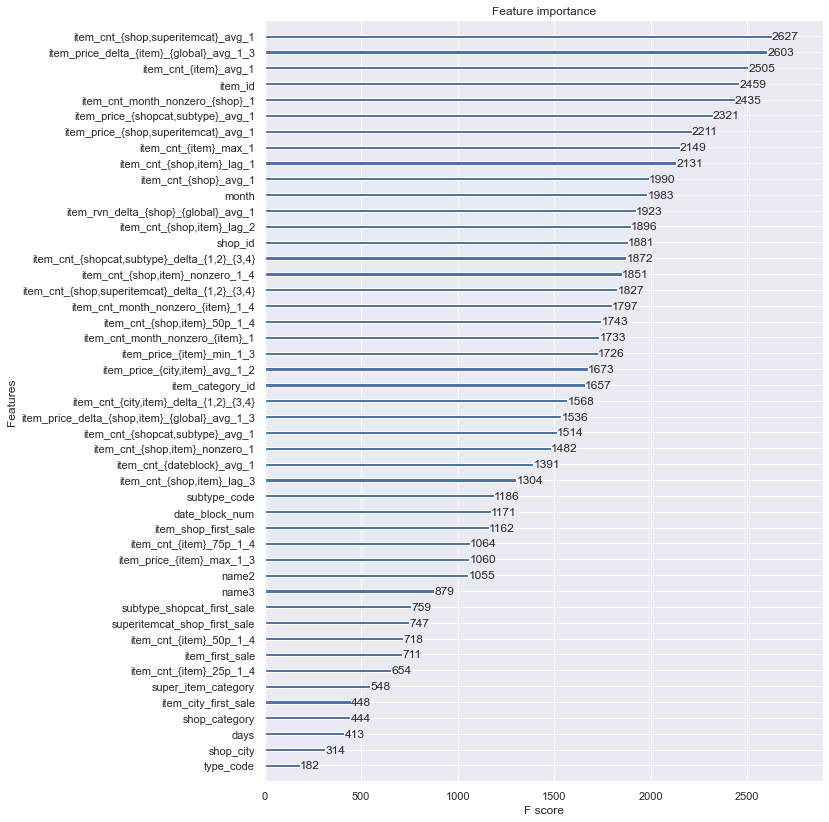

In [1331]:
from xgboost import plot_importance

def plot_features(booster, figsize):    
    fig, ax = plt.subplots(1,1,figsize=figsize)
    return plot_importance(booster=booster, ax=ax)

plot_features(model, (10,14))

# XGBoost Model (Shop)

In [1332]:
uniq_shop_ids = X_test.shop_id.unique()
shops_train = X_train.shop_id
shops_valid = X_valid.shop_id
shops_test = X_test.shop_id

In [1333]:

drop_cols = ['shop_id']
            
        
xgb_cols_byshop = [x for x in xgb_cols if x not in drop_cols]

def model_by_shop():
    
    models = []
    
    Y_pred = np.zeros([X_valid.shape[0], 1])
    Y_test = np.zeros([X_test.shape[0], 1])

    cur_block_num=34
   
    miss_shop = []

    for shopid in uniq_shop_ids:


        mask_train = (shops_train==shopid).values.flatten()
        mask_valid = (shops_valid==shopid).values.flatten()
        mask_test = (shops_test==shopid).values.flatten()
        
        print(shopid,np.sum(mask_train),np.sum(mask_valid),np.sum(mask_test))
        
        if np.sum(mask_train)<1000 or np.sum(mask_valid)<300:
            miss_shop.append(shopid)
            continue
        
        model = XGBRegressor(
                    max_depth=10, #10
                    n_estimators=1000,
                    min_child_weight= 16, #16
                    colsample_bytree=0.8, 
                    subsample=0.8, 
                    eta=0.09,
                    tree_method='gpu_hist',
                    seed=42)

            

        model.fit(
            X_train[xgb_cols_byshop][mask_train],
            Y_train[mask_train],
            eval_metric="rmse", 
            eval_set=[(X_train[xgb_cols_byshop][mask_train], Y_train[mask_train]),
                      (X_valid[xgb_cols_byshop][mask_valid], Y_valid[mask_valid])], 
            verbose=True, 
            early_stopping_rounds = 20)    
        
        models.append(model)

        Y_pred[mask_valid,0] = model.predict(X_valid[xgb_cols_byshop][mask_valid]).flatten()
        Y_test[mask_test,0] = model.predict(X_test[xgb_cols_byshop][mask_test]).flatten()
    
    return Y_test,Y_pred,miss_shop,models

In [1334]:
Y_test_byshop,Y_pred_byshop,miss_shop,models_byshop = model_by_shop()

Y_test_byshop = np.clip(Y_test_byshop.flatten(),0, 20)

5 195768 5413 5100
[0]	validation_0-rmse:0.84476	validation_1-rmse:0.82007
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 20 rounds.
[1]	validation_0-rmse:0.80802	validation_1-rmse:0.78778
[2]	validation_0-rmse:0.77617	validation_1-rmse:0.76146
[3]	validation_0-rmse:0.74814	validation_1-rmse:0.73605
[4]	validation_0-rmse:0.72322	validation_1-rmse:0.71455
[5]	validation_0-rmse:0.70037	validation_1-rmse:0.69390
[6]	validation_0-rmse:0.68029	validation_1-rmse:0.67675
[7]	validation_0-rmse:0.66232	validation_1-rmse:0.66468
[8]	validation_0-rmse:0.64746	validation_1-rmse:0.65615
[9]	validation_0-rmse:0.63423	validation_1-rmse:0.64882
[10]	validation_0-rmse:0.62255	validation_1-rmse:0.64256
[11]	validation_0-rmse:0.61251	validation_1-rmse:0.63700
[12]	validation_0-rmse:0.60350	validation_1-rmse:0.63105
[13]	validation_0-rmse:0.59566	validation_1-rmse:0.62780
[14]	validation_0-rmse:0.58865	val

[20]	validation_0-rmse:0.85797	validation_1-rmse:0.83882
[21]	validation_0-rmse:0.85274	validation_1-rmse:0.83841
[22]	validation_0-rmse:0.84798	validation_1-rmse:0.83832
[23]	validation_0-rmse:0.84387	validation_1-rmse:0.83833
[24]	validation_0-rmse:0.83845	validation_1-rmse:0.83976
[25]	validation_0-rmse:0.83448	validation_1-rmse:0.84026
[26]	validation_0-rmse:0.82976	validation_1-rmse:0.84061
[27]	validation_0-rmse:0.82647	validation_1-rmse:0.84073
[28]	validation_0-rmse:0.82263	validation_1-rmse:0.84305
[29]	validation_0-rmse:0.81902	validation_1-rmse:0.84409
[30]	validation_0-rmse:0.81615	validation_1-rmse:0.84612
[31]	validation_0-rmse:0.81399	validation_1-rmse:0.84528
[32]	validation_0-rmse:0.81114	validation_1-rmse:0.84737
[33]	validation_0-rmse:0.80919	validation_1-rmse:0.84721
[34]	validation_0-rmse:0.80681	validation_1-rmse:0.84678
[35]	validation_0-rmse:0.80360	validation_1-rmse:0.84613
[36]	validation_0-rmse:0.80150	validation_1-rmse:0.84663
[37]	validation_0-rmse:0.80031	

[11]	validation_0-rmse:0.74046	validation_1-rmse:0.72225
[12]	validation_0-rmse:0.72844	validation_1-rmse:0.71471
[13]	validation_0-rmse:0.71831	validation_1-rmse:0.70921
[14]	validation_0-rmse:0.70930	validation_1-rmse:0.70476
[15]	validation_0-rmse:0.70065	validation_1-rmse:0.69877
[16]	validation_0-rmse:0.69273	validation_1-rmse:0.69515
[17]	validation_0-rmse:0.68623	validation_1-rmse:0.69388
[18]	validation_0-rmse:0.67991	validation_1-rmse:0.69087
[19]	validation_0-rmse:0.67419	validation_1-rmse:0.68698
[20]	validation_0-rmse:0.66896	validation_1-rmse:0.68489
[21]	validation_0-rmse:0.66397	validation_1-rmse:0.68131
[22]	validation_0-rmse:0.65952	validation_1-rmse:0.68165
[23]	validation_0-rmse:0.65546	validation_1-rmse:0.67969
[24]	validation_0-rmse:0.65173	validation_1-rmse:0.67796
[25]	validation_0-rmse:0.64814	validation_1-rmse:0.67621
[26]	validation_0-rmse:0.64456	validation_1-rmse:0.67611
[27]	validation_0-rmse:0.64158	validation_1-rmse:0.67473
[28]	validation_0-rmse:0.63879	

[3]	validation_0-rmse:1.69705	validation_1-rmse:1.25372
[4]	validation_0-rmse:1.63694	validation_1-rmse:1.22006
[5]	validation_0-rmse:1.58255	validation_1-rmse:1.18870
[6]	validation_0-rmse:1.53394	validation_1-rmse:1.16592
[7]	validation_0-rmse:1.49157	validation_1-rmse:1.14929
[8]	validation_0-rmse:1.45604	validation_1-rmse:1.13615
[9]	validation_0-rmse:1.42401	validation_1-rmse:1.12797
[10]	validation_0-rmse:1.39477	validation_1-rmse:1.11736
[11]	validation_0-rmse:1.36802	validation_1-rmse:1.10959
[12]	validation_0-rmse:1.34595	validation_1-rmse:1.10322
[13]	validation_0-rmse:1.32681	validation_1-rmse:1.09974
[14]	validation_0-rmse:1.30965	validation_1-rmse:1.09723
[15]	validation_0-rmse:1.29467	validation_1-rmse:1.09398
[16]	validation_0-rmse:1.28130	validation_1-rmse:1.09365
[17]	validation_0-rmse:1.26867	validation_1-rmse:1.08943
[18]	validation_0-rmse:1.25648	validation_1-rmse:1.08697
[19]	validation_0-rmse:1.24579	validation_1-rmse:1.08650
[20]	validation_0-rmse:1.23648	validat

[18]	validation_0-rmse:0.74477	validation_1-rmse:0.82372
[19]	validation_0-rmse:0.73976	validation_1-rmse:0.82178
[20]	validation_0-rmse:0.73482	validation_1-rmse:0.82270
[21]	validation_0-rmse:0.73092	validation_1-rmse:0.82355
[22]	validation_0-rmse:0.72689	validation_1-rmse:0.82311
[23]	validation_0-rmse:0.72405	validation_1-rmse:0.82234
[24]	validation_0-rmse:0.71897	validation_1-rmse:0.82376
[25]	validation_0-rmse:0.71608	validation_1-rmse:0.82347
[26]	validation_0-rmse:0.71218	validation_1-rmse:0.82152
[27]	validation_0-rmse:0.70939	validation_1-rmse:0.82327
[28]	validation_0-rmse:0.70650	validation_1-rmse:0.82403
[29]	validation_0-rmse:0.70381	validation_1-rmse:0.82354
[30]	validation_0-rmse:0.70084	validation_1-rmse:0.82370
[31]	validation_0-rmse:0.69854	validation_1-rmse:0.82639
[32]	validation_0-rmse:0.69699	validation_1-rmse:0.82592
[33]	validation_0-rmse:0.69579	validation_1-rmse:0.82599
[34]	validation_0-rmse:0.69361	validation_1-rmse:0.82700
[35]	validation_0-rmse:0.69132	

[12]	validation_0-rmse:0.73482	validation_1-rmse:0.82734
[13]	validation_0-rmse:0.72198	validation_1-rmse:0.81731
[14]	validation_0-rmse:0.71005	validation_1-rmse:0.80938
[15]	validation_0-rmse:0.69887	validation_1-rmse:0.79691
[16]	validation_0-rmse:0.68967	validation_1-rmse:0.78941
[17]	validation_0-rmse:0.68153	validation_1-rmse:0.78506
[18]	validation_0-rmse:0.67463	validation_1-rmse:0.77792
[19]	validation_0-rmse:0.66755	validation_1-rmse:0.77378
[20]	validation_0-rmse:0.66247	validation_1-rmse:0.77165
[21]	validation_0-rmse:0.65578	validation_1-rmse:0.76774
[22]	validation_0-rmse:0.65157	validation_1-rmse:0.76525
[23]	validation_0-rmse:0.64759	validation_1-rmse:0.76257
[24]	validation_0-rmse:0.64443	validation_1-rmse:0.76190
[25]	validation_0-rmse:0.64084	validation_1-rmse:0.75970
[26]	validation_0-rmse:0.63783	validation_1-rmse:0.75904
[27]	validation_0-rmse:0.63530	validation_1-rmse:0.75929
[28]	validation_0-rmse:0.63294	validation_1-rmse:0.75801
[29]	validation_0-rmse:0.63004	

[23]	validation_0-rmse:0.70496	validation_1-rmse:0.84891
[24]	validation_0-rmse:0.70225	validation_1-rmse:0.84795
[25]	validation_0-rmse:0.69970	validation_1-rmse:0.84749
[26]	validation_0-rmse:0.69760	validation_1-rmse:0.84639
[27]	validation_0-rmse:0.69528	validation_1-rmse:0.84690
[28]	validation_0-rmse:0.69301	validation_1-rmse:0.84681
[29]	validation_0-rmse:0.69100	validation_1-rmse:0.84622
[30]	validation_0-rmse:0.68921	validation_1-rmse:0.84615
[31]	validation_0-rmse:0.68821	validation_1-rmse:0.84612
[32]	validation_0-rmse:0.68687	validation_1-rmse:0.84589
[33]	validation_0-rmse:0.68577	validation_1-rmse:0.84525
[34]	validation_0-rmse:0.68412	validation_1-rmse:0.84774
[35]	validation_0-rmse:0.68210	validation_1-rmse:0.84727
[36]	validation_0-rmse:0.68124	validation_1-rmse:0.84694
[37]	validation_0-rmse:0.67997	validation_1-rmse:0.84805
[38]	validation_0-rmse:0.67868	validation_1-rmse:0.84811
[39]	validation_0-rmse:0.67730	validation_1-rmse:0.84809
[40]	validation_0-rmse:0.67680	

[3]	validation_0-rmse:0.92907	validation_1-rmse:0.83495
[4]	validation_0-rmse:0.89540	validation_1-rmse:0.81310
[5]	validation_0-rmse:0.86489	validation_1-rmse:0.79416
[6]	validation_0-rmse:0.83839	validation_1-rmse:0.77966
[7]	validation_0-rmse:0.81408	validation_1-rmse:0.76547
[8]	validation_0-rmse:0.79214	validation_1-rmse:0.75638
[9]	validation_0-rmse:0.77403	validation_1-rmse:0.75002
[10]	validation_0-rmse:0.75766	validation_1-rmse:0.74228
[11]	validation_0-rmse:0.74263	validation_1-rmse:0.73239
[12]	validation_0-rmse:0.72953	validation_1-rmse:0.73034
[13]	validation_0-rmse:0.71783	validation_1-rmse:0.72669
[14]	validation_0-rmse:0.70714	validation_1-rmse:0.72404
[15]	validation_0-rmse:0.69793	validation_1-rmse:0.72080
[16]	validation_0-rmse:0.69070	validation_1-rmse:0.71784
[17]	validation_0-rmse:0.68320	validation_1-rmse:0.71795
[18]	validation_0-rmse:0.67578	validation_1-rmse:0.71518
[19]	validation_0-rmse:0.66906	validation_1-rmse:0.71376
[20]	validation_0-rmse:0.66305	validat

[7]	validation_0-rmse:1.26448	validation_1-rmse:1.57548
[8]	validation_0-rmse:1.23700	validation_1-rmse:1.55498
[9]	validation_0-rmse:1.21449	validation_1-rmse:1.53587
[10]	validation_0-rmse:1.19334	validation_1-rmse:1.51514
[11]	validation_0-rmse:1.17429	validation_1-rmse:1.50188
[12]	validation_0-rmse:1.15767	validation_1-rmse:1.49055
[13]	validation_0-rmse:1.14307	validation_1-rmse:1.48446
[14]	validation_0-rmse:1.12917	validation_1-rmse:1.47772
[15]	validation_0-rmse:1.11667	validation_1-rmse:1.47306
[16]	validation_0-rmse:1.10556	validation_1-rmse:1.46746
[17]	validation_0-rmse:1.09697	validation_1-rmse:1.46289
[18]	validation_0-rmse:1.08821	validation_1-rmse:1.45945
[19]	validation_0-rmse:1.08024	validation_1-rmse:1.45585
[20]	validation_0-rmse:1.07225	validation_1-rmse:1.45454
[21]	validation_0-rmse:1.06630	validation_1-rmse:1.45441
[22]	validation_0-rmse:1.06068	validation_1-rmse:1.45241
[23]	validation_0-rmse:1.05530	validation_1-rmse:1.44870
[24]	validation_0-rmse:1.04941	val

[1]	validation_0-rmse:0.62399	validation_1-rmse:0.58403
[2]	validation_0-rmse:0.59491	validation_1-rmse:0.56114
[3]	validation_0-rmse:0.56854	validation_1-rmse:0.53821
[4]	validation_0-rmse:0.54529	validation_1-rmse:0.51714
[5]	validation_0-rmse:0.52443	validation_1-rmse:0.49885
[6]	validation_0-rmse:0.50673	validation_1-rmse:0.48717
[7]	validation_0-rmse:0.49141	validation_1-rmse:0.47752
[8]	validation_0-rmse:0.47739	validation_1-rmse:0.46886
[9]	validation_0-rmse:0.46551	validation_1-rmse:0.46142
[10]	validation_0-rmse:0.45487	validation_1-rmse:0.45749
[11]	validation_0-rmse:0.44547	validation_1-rmse:0.44991
[12]	validation_0-rmse:0.43721	validation_1-rmse:0.44448
[13]	validation_0-rmse:0.43000	validation_1-rmse:0.44155
[14]	validation_0-rmse:0.42329	validation_1-rmse:0.43839
[15]	validation_0-rmse:0.41799	validation_1-rmse:0.43582
[16]	validation_0-rmse:0.41286	validation_1-rmse:0.43504
[17]	validation_0-rmse:0.40870	validation_1-rmse:0.43326
[18]	validation_0-rmse:0.40507	validatio

[3]	validation_0-rmse:0.93533	validation_1-rmse:0.98365
[4]	validation_0-rmse:0.90135	validation_1-rmse:0.95731
[5]	validation_0-rmse:0.87074	validation_1-rmse:0.93403
[6]	validation_0-rmse:0.84412	validation_1-rmse:0.91733
[7]	validation_0-rmse:0.82092	validation_1-rmse:0.90453
[8]	validation_0-rmse:0.79983	validation_1-rmse:0.89393
[9]	validation_0-rmse:0.78182	validation_1-rmse:0.88592
[10]	validation_0-rmse:0.76524	validation_1-rmse:0.87966
[11]	validation_0-rmse:0.75064	validation_1-rmse:0.87188
[12]	validation_0-rmse:0.73788	validation_1-rmse:0.86586
[13]	validation_0-rmse:0.72714	validation_1-rmse:0.86310
[14]	validation_0-rmse:0.71741	validation_1-rmse:0.85959
[15]	validation_0-rmse:0.70810	validation_1-rmse:0.85956
[16]	validation_0-rmse:0.69968	validation_1-rmse:0.85790
[17]	validation_0-rmse:0.69175	validation_1-rmse:0.85806
[18]	validation_0-rmse:0.68482	validation_1-rmse:0.85666
[19]	validation_0-rmse:0.67858	validation_1-rmse:0.85492
[20]	validation_0-rmse:0.67313	validat

[28]	validation_0-rmse:1.02104	validation_1-rmse:0.82124
[29]	validation_0-rmse:1.01746	validation_1-rmse:0.82310
[30]	validation_0-rmse:1.01354	validation_1-rmse:0.82378
[31]	validation_0-rmse:1.01042	validation_1-rmse:0.82349
[32]	validation_0-rmse:1.00663	validation_1-rmse:0.82281
[33]	validation_0-rmse:1.00356	validation_1-rmse:0.82292
[34]	validation_0-rmse:1.00072	validation_1-rmse:0.82412
[35]	validation_0-rmse:0.99788	validation_1-rmse:0.82540
[36]	validation_0-rmse:0.99536	validation_1-rmse:0.82460
[37]	validation_0-rmse:0.99289	validation_1-rmse:0.82400
Stopping. Best iteration:
[17]	validation_0-rmse:1.09643	validation_1-rmse:0.81791

58 195768 5413 5100
[0]	validation_0-rmse:1.21869	validation_1-rmse:0.90285
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 20 rounds.
[1]	validation_0-rmse:1.16259	validation_1-rmse:0.86796
[2]	validation_0-rmse:1.11286	validation_1-rmse:0.84009

[23]	validation_0-rmse:0.58411	validation_1-rmse:0.54031
[24]	validation_0-rmse:0.58066	validation_1-rmse:0.54085
[25]	validation_0-rmse:0.57750	validation_1-rmse:0.54025
[26]	validation_0-rmse:0.57484	validation_1-rmse:0.53973
[27]	validation_0-rmse:0.57269	validation_1-rmse:0.54077
[28]	validation_0-rmse:0.56995	validation_1-rmse:0.54085
[29]	validation_0-rmse:0.56774	validation_1-rmse:0.54115
[30]	validation_0-rmse:0.56514	validation_1-rmse:0.54113
[31]	validation_0-rmse:0.56334	validation_1-rmse:0.54258
[32]	validation_0-rmse:0.56181	validation_1-rmse:0.54261
[33]	validation_0-rmse:0.56070	validation_1-rmse:0.54441
[34]	validation_0-rmse:0.55864	validation_1-rmse:0.54425
[35]	validation_0-rmse:0.55731	validation_1-rmse:0.54532
[36]	validation_0-rmse:0.55562	validation_1-rmse:0.54636
[37]	validation_0-rmse:0.55454	validation_1-rmse:0.54571
[38]	validation_0-rmse:0.55328	validation_1-rmse:0.54572
[39]	validation_0-rmse:0.55257	validation_1-rmse:0.54602
[40]	validation_0-rmse:0.55122	

[60]	validation_0-rmse:0.65875	validation_1-rmse:0.58687
[61]	validation_0-rmse:0.65790	validation_1-rmse:0.58678
[62]	validation_0-rmse:0.65681	validation_1-rmse:0.58658
[63]	validation_0-rmse:0.65646	validation_1-rmse:0.58660
[64]	validation_0-rmse:0.65610	validation_1-rmse:0.58649
[65]	validation_0-rmse:0.65595	validation_1-rmse:0.58660
[66]	validation_0-rmse:0.65560	validation_1-rmse:0.58629
[67]	validation_0-rmse:0.65500	validation_1-rmse:0.58617
[68]	validation_0-rmse:0.65475	validation_1-rmse:0.58621
[69]	validation_0-rmse:0.65389	validation_1-rmse:0.58596
[70]	validation_0-rmse:0.65285	validation_1-rmse:0.58590
[71]	validation_0-rmse:0.65241	validation_1-rmse:0.58593
[72]	validation_0-rmse:0.65216	validation_1-rmse:0.58603
[73]	validation_0-rmse:0.65165	validation_1-rmse:0.58611
[74]	validation_0-rmse:0.65103	validation_1-rmse:0.58643
[75]	validation_0-rmse:0.65068	validation_1-rmse:0.58622
[76]	validation_0-rmse:0.65045	validation_1-rmse:0.58650
[77]	validation_0-rmse:0.65030	

[34]	validation_0-rmse:0.66704	validation_1-rmse:0.74893
[35]	validation_0-rmse:0.66553	validation_1-rmse:0.75029
[36]	validation_0-rmse:0.66392	validation_1-rmse:0.75101
[37]	validation_0-rmse:0.66279	validation_1-rmse:0.75127
[38]	validation_0-rmse:0.66213	validation_1-rmse:0.75191
[39]	validation_0-rmse:0.66009	validation_1-rmse:0.75152
Stopping. Best iteration:
[19]	validation_0-rmse:0.71297	validation_1-rmse:0.73779

38 195768 5413 5100
[0]	validation_0-rmse:0.98848	validation_1-rmse:0.88867
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 20 rounds.
[1]	validation_0-rmse:0.94378	validation_1-rmse:0.85124
[2]	validation_0-rmse:0.90464	validation_1-rmse:0.81994
[3]	validation_0-rmse:0.86981	validation_1-rmse:0.79241
[4]	validation_0-rmse:0.83817	validation_1-rmse:0.76936
[5]	validation_0-rmse:0.80996	validation_1-rmse:0.74755
[6]	validation_0-rmse:0.78492	validation_1-rmse:0.72916
[7]

[87]	validation_0-rmse:0.29822	validation_1-rmse:0.41772
[88]	validation_0-rmse:0.29779	validation_1-rmse:0.41758
[89]	validation_0-rmse:0.29768	validation_1-rmse:0.41736
[90]	validation_0-rmse:0.29747	validation_1-rmse:0.41760
[91]	validation_0-rmse:0.29733	validation_1-rmse:0.41763
[92]	validation_0-rmse:0.29720	validation_1-rmse:0.41759
[93]	validation_0-rmse:0.29692	validation_1-rmse:0.41739
[94]	validation_0-rmse:0.29679	validation_1-rmse:0.41746
[95]	validation_0-rmse:0.29663	validation_1-rmse:0.41749
[96]	validation_0-rmse:0.29650	validation_1-rmse:0.41756
[97]	validation_0-rmse:0.29624	validation_1-rmse:0.41747
[98]	validation_0-rmse:0.29600	validation_1-rmse:0.41758
[99]	validation_0-rmse:0.29587	validation_1-rmse:0.41776
[100]	validation_0-rmse:0.29570	validation_1-rmse:0.41766
[101]	validation_0-rmse:0.29544	validation_1-rmse:0.41818
[102]	validation_0-rmse:0.29526	validation_1-rmse:0.41801
[103]	validation_0-rmse:0.29506	validation_1-rmse:0.41814
[104]	validation_0-rmse:0.2

[69]	validation_0-rmse:0.54800	validation_1-rmse:0.50633
[70]	validation_0-rmse:0.54758	validation_1-rmse:0.50612
[71]	validation_0-rmse:0.54652	validation_1-rmse:0.50632
[72]	validation_0-rmse:0.54633	validation_1-rmse:0.50656
[73]	validation_0-rmse:0.54578	validation_1-rmse:0.50638
[74]	validation_0-rmse:0.54513	validation_1-rmse:0.50656
[75]	validation_0-rmse:0.54487	validation_1-rmse:0.50616
[76]	validation_0-rmse:0.54439	validation_1-rmse:0.50610
[77]	validation_0-rmse:0.54404	validation_1-rmse:0.50561
[78]	validation_0-rmse:0.54375	validation_1-rmse:0.50560
[79]	validation_0-rmse:0.54360	validation_1-rmse:0.50588
[80]	validation_0-rmse:0.54325	validation_1-rmse:0.50564
[81]	validation_0-rmse:0.54252	validation_1-rmse:0.50559
[82]	validation_0-rmse:0.54183	validation_1-rmse:0.50561
[83]	validation_0-rmse:0.54153	validation_1-rmse:0.50532
[84]	validation_0-rmse:0.54090	validation_1-rmse:0.50578
[85]	validation_0-rmse:0.53997	validation_1-rmse:0.50619
[86]	validation_0-rmse:0.53969	

[26]	validation_0-rmse:0.45138	validation_1-rmse:0.81744
[27]	validation_0-rmse:0.44986	validation_1-rmse:0.81694
[28]	validation_0-rmse:0.44858	validation_1-rmse:0.81675
[29]	validation_0-rmse:0.44684	validation_1-rmse:0.81748
[30]	validation_0-rmse:0.44590	validation_1-rmse:0.81863
[31]	validation_0-rmse:0.44499	validation_1-rmse:0.81875
[32]	validation_0-rmse:0.44423	validation_1-rmse:0.81880
[33]	validation_0-rmse:0.44331	validation_1-rmse:0.81941
[34]	validation_0-rmse:0.44249	validation_1-rmse:0.81976
[35]	validation_0-rmse:0.44100	validation_1-rmse:0.81993
[36]	validation_0-rmse:0.44011	validation_1-rmse:0.82120
[37]	validation_0-rmse:0.43946	validation_1-rmse:0.82102
[38]	validation_0-rmse:0.43898	validation_1-rmse:0.82092
[39]	validation_0-rmse:0.43785	validation_1-rmse:0.82077
[40]	validation_0-rmse:0.43711	validation_1-rmse:0.82020
[41]	validation_0-rmse:0.43623	validation_1-rmse:0.81999
[42]	validation_0-rmse:0.43581	validation_1-rmse:0.82000
[43]	validation_0-rmse:0.43508	

In [1335]:
Y_pred_byshop = Y_pred_byshop.clip(0,20).flatten()

# Ensemble by Shop Id

In [1562]:
Y_test_ensem = np.zeros(X_test.shape[0])
Y_pred_ensem = np.zeros(X_valid.shape[0])

for shopid in uniq_shop_ids:
    mask_valid = (shops_valid==shopid).values.flatten()
    mask_test = (shops_test==shopid).values.flatten()
    xgb_val_loss = np.sqrt(np.mean((Y_valid[mask_valid]-Y_pred[mask_valid])**2))
    net_val_loss = np.sqrt(np.mean((Y_valid[mask_valid]-Y_pred_byshop[mask_valid].flatten())**2))
    
    if shopid in miss_shop:
        Y_test_ensem[mask_test] = Y_test[mask_test]
        Y_valid_ensem[mask_valid] = Y_pred[mask_valid]
    elif xgb_val_loss+0.01<net_val_loss:
        Y_test_ensem[mask_test] = Y_test[mask_test]
        Y_pred_ensem[mask_valid] = Y_pred[mask_valid]
    else:
        Y_test_ensem[mask_test] = Y_test[mask_test]*0.5 + Y_test_byshop[mask_test].flatten()*0.5
        Y_pred_ensem[mask_valid] = Y_pred[mask_valid]*0.5 + Y_pred_byshop[mask_valid].flatten()*0.5
    
    print(shopid,xgb_val_loss,net_val_loss,xgb_val_loss+0.01>net_val_loss)

5 0.613117 0.6153508512245094 True
4 0.5085742 0.4873373286853029 True
6 0.8410979 0.8383178825433667 True
3 0.46524352 0.4553986193147611 True
2 0.5804995 0.5871472120860235 True
7 0.6722357 0.6721781864193485 True
11 0.46222314 0.4350935001683329 True
12 0.91507655 0.8417569898501419 True
28 1.0793144 1.084377028282821 True
31 1.5030216 1.5135409133417206 False
26 0.8086995 0.8215154646011948 False
25 1.6406517 1.6103746166277053 True
22 0.7610298 0.7422215444694203 True
24 0.7428951 0.7840448241107772 False
21 0.85093206 0.8452446324119027 True
15 0.68937916 0.6918474041274361 True
16 0.59190863 0.5887685729654009 True
18 0.7125477 0.7112910266913247 True
14 0.6400821 0.627382669471857 True
19 0.74003476 0.7474861111867287 True
42 1.4599698 1.4380435960157203 True
50 0.6090966 0.6091144994985681 True
49 0.4231683 0.426758256098967 True
53 0.6159992 0.6397067064069168 False
52 0.529848 0.5414521042415906 False
47 0.8238388 0.8541703244128593 False
48 0.6354564 0.6507648692728283 Fals

In [1337]:
np.mean(Y_test),np.mean(Y_test_byshop)

(0.2883679, 0.3190253585614577)

In [1338]:
print(Y_test_ensem.mean())

submission = pd.DataFrame({
    "ID": test.index, 
    "item_cnt_month": Y_test_ensem
})
submission.to_csv('ensemble_submission.csv', index=False)

0.2936245120497617


# Neural Network (Super Item Category)

In [1339]:
#Standard Pipeline Libraries
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import FunctionTransformer

In [544]:
import tensorflow as tf

In [1474]:
def create_datasets():
    
    valid_mask = data.date_block_num.isin([33])
    train_mask = ~valid_mask&(data.date_block_num<34)&(data.date_block_num>=12)
    
    valid_mask = valid_mask&~((data.shop_id==36)&data.date_block_num.isin([33]))
    
    test_mask = data.date_block_num == 34
    
    X_train = data[train_mask]
    Y_train = data[train_mask]['item_cnt_month']
    X_valid = data[valid_mask]
    Y_valid = data[valid_mask]['item_cnt_month']
    X_test = data[test_mask]
    
    return X_train,Y_train,X_valid,Y_valid,X_test


X_train,Y_train,X_valid,Y_valid,X_test = create_datasets()


Y_train = Y_train.clip(0, 20)
Y_valid = Y_valid.clip(0, 20)


net_transformer = Pipeline([
            ('fillna',SimpleImputer(strategy='median')),
            ('scaler', StandardScaler()),
            
        ])


        
net_cols = ['item_cnt_{shop,item}_lag_1',
 'item_cnt_{shop,item}_lag_2',
 'item_cnt_{shop,item}_lag_3',
 'item_cnt_{shop,item}_nonzero_1',
 'item_cnt_{shop,item}_50p_1_4',
 'item_cnt_{shop,item}_nonzero_1_4',
 'item_cnt_{dateblock}_avg_1',
 'item_cnt_{item}_avg_1',
 'item_cnt_{item}_max_1',
 'item_cnt_month_nonzero_{item}_1',
 'item_cnt_{item}_25p_1_4',
 'item_cnt_{item}_50p_1_4',
 'item_cnt_{item}_75p_1_4',
 'item_cnt_month_nonzero_{item}_1_4',
 'item_cnt_{shop}_avg_1',
 'item_cnt_month_nonzero_{shop}_1',
 'item_price_{shopcat,subtype}_avg_1',
 'item_cnt_{shopcat,subtype}_avg_1',
 'item_cnt_{shopcat,subtype}_delta_{1,2}_{3,4}',
 'item_price_{shop,superitemcat}_avg_1',
 'item_cnt_{shop,superitemcat}_avg_1',
 'item_cnt_{shop,superitemcat}_delta_{1,2}_{3,4}',
 'item_price_{city,item}_avg_1_2',
 'item_cnt_{city,item}_delta_{1,2}_{3,4}',
 'item_price_{item}_min_1_3',
 'item_price_{item}_max_1_3',
 'item_price_delta_{item}_{global}_avg_1_3',
 'item_price_delta_{shop,item}_{global}_avg_1_3',
 'item_rvn_delta_{shop}_{global}_avg_1',
'item_cnt_{shop,item}_sum_3_6',
'item_cnt_{shop,item}_sum_6_9',
'item_cnt_{shop,item}_sum_9_12',
'item_name_hashvec_0', 'item_name_hashvec_1',
'item_name_hashvec_2', 'item_name_hashvec_3', 'item_name_hashvec_4',
'item_name_hashvec_5', 'item_name_hashvec_6', 'item_name_hashvec_7',
'item_name_hashvec_8', 'item_name_hashvec_9',
'item_rvn_delta_{shop}_{global}_avg_1', 'item_shop_first_sale',
'item_city_first_sale', 'superitemcat_shop_first_sale',
'subtype_shopcat_first_sale', 'item_first_sale']


sic_train = X_train.super_item_category
sic_valid = X_valid.super_item_category
sic_test = X_test.super_item_category

city_train = X_train.shop_city
city_valid = X_valid.shop_city
city_test = X_test.shop_city

subtype_train = X_train.subtype_code
subtype_valid = X_valid.subtype_code
subtype_test = X_test.subtype_code

uniq_sic_ids = X_test.super_item_category.unique()
uniq_city_ids = X_test.shop_city.unique()
uniq_subtype_ids = X_test.subtype_code.unique()

In [1483]:
def model_by_sic():
    
    models = []
    
    Y_pred = np.zeros([X_valid.shape[0], 1])
    Y_test = np.zeros([X_test.shape[0], 1])

    cur_block_num=34
   
    miss_shop = []

    for sicid in uniq_sic_ids:


        mask_train = (sic_train==sicid).values.flatten()
        mask_valid = (sic_valid==sicid).values.flatten()
        mask_test = (sic_test==sicid).values.flatten()
        
        net_transformer.fit(X_train[net_cols][mask_train])
        X_train_t = net_transformer.transform(X_train[net_cols][mask_train])
        X_valid_t = net_transformer.transform(X_valid[net_cols][mask_valid])
        X_test_t = net_transformer.transform(X_test[net_cols][mask_test])
        Y_train_t = Y_train[mask_train]
        Y_valid_t = Y_valid[mask_valid]
        
        print(sicid,np.sum(mask_train),np.sum(mask_valid),np.sum(mask_test))
        
        if np.sum(mask_train)<300 or np.sum(mask_valid)<300:
            miss_shop.append(sicid)
            continue
        
        
        es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=5,
                                     verbose=1, mode='auto', baseline=None, restore_best_weights=True)
        model = tf.keras.Sequential()

        model.add(tf.keras.layers.Dense(64,activation='linear',kernel_regularizer=tf.keras.regularizers.L1(0.01),))
        model.add(tf.keras.layers.Dense(1,activation='linear'))

        model.compile(loss=tf.keras.losses.MeanSquaredError(),
                      metrics=[tf.keras.metrics.RootMeanSquaredError()],
                      optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))

        model.fit(X_train_t, Y_train_t,
                      validation_data=(X_valid_t, Y_valid_t), 
                      verbose=1,
                      batch_size=128,
                      epochs=1000,
                      callbacks=[es])

        
        models.append(model)

        Y_pred[mask_valid,0] = model.predict(X_valid_t).flatten()
        Y_test[mask_test,0] = model.predict(X_test_t).flatten()
    
    return Y_test,Y_pred,miss_shop,models

In [1484]:
Y_test_bysic,Y_pred_bysic,miss_sic,_ = model_by_sic()

Y_test_bysic = np.clip(Y_test_bysic.flatten(),0, 20)
Y_pred_bysic = np.clip(Y_pred_bysic.flatten(),0, 20)

7 519681 22962 23268
Epoch 1/1000
   1/4061 [..............................] - ETA: 0s - loss: 7.1001 - root_mean_squared_error: 1.8888

4061/4061 [==============================] - 2s 475us/step - loss: 2.9160 - root_mean_squared_error: 1.5303 - val_loss: 2.5916 - val_root_mean_squared_error: 1.5768
Epoch 2/1000
4061/4061 [==============================] - 2s 443us/step - loss: 2.3971 - root_mean_squared_error: 1.5219 - val_loss: 2.5495 - val_root_mean_squared_error: 1.5763
Epoch 3/1000
4061/4061 [==============================] - 2s 441us/step - loss: 2.3636 - root_mean_squared_error: 1.5185 - val_loss: 2.5559 - val_root_mean_squared_error: 1.5832
Epoch 4/1000
4061/4061 [==============================] - 2s 435us/step - loss: 2.3552 - root_mean_squared_error: 1.5181 - val_loss: 2.5969 - val_root_mean_squared_error: 1.5967
Epoch 5/1000
4061/4061 [==============================] - 2s 431us/step - loss: 2.3479 - root_mean_squared_error: 1.5175 - val_loss: 2.5608 - val_root_mean_squared_error: 1.5841
Epoch 6/1000
4061/4061 [==============================] - 2s 436us/step - loss: 2.3443 - root_mean_squared_error: 1.5172 - 

681/681 [==============================] - 0s 459us/step - loss: 1.8130 - root_mean_squared_error: 1.1179 - val_loss: 1.0754 - val_root_mean_squared_error: 0.8637
Epoch 3/1000
681/681 [==============================] - 0s 461us/step - loss: 1.4606 - root_mean_squared_error: 1.1186 - val_loss: 0.8430 - val_root_mean_squared_error: 0.8448
Epoch 4/1000
681/681 [==============================] - 0s 503us/step - loss: 1.3687 - root_mean_squared_error: 1.1222 - val_loss: 0.8425 - val_root_mean_squared_error: 0.8709
Epoch 5/1000
681/681 [==============================] - 0s 470us/step - loss: 1.3403 - root_mean_squared_error: 1.1204 - val_loss: 0.7502 - val_root_mean_squared_error: 0.8171
Epoch 6/1000
681/681 [==============================] - 0s 488us/step - loss: 1.3314 - root_mean_squared_error: 1.1195 - val_loss: 0.7243 - val_root_mean_squared_error: 0.8005
Epoch 7/1000
681/681 [==============================] - 0s 473us/step - loss: 1.3259 - root_mean_squared_error: 1.1196 - val_loss: 0.

Epoch 20/1000
298/298 [==============================] - 0s 475us/step - loss: 1.6841 - root_mean_squared_error: 1.2502 - val_loss: 0.4546 - val_root_mean_squared_error: 0.5749
Epoch 21/1000
298/298 [==============================] - 0s 468us/step - loss: 1.6712 - root_mean_squared_error: 1.2463 - val_loss: 0.4303 - val_root_mean_squared_error: 0.5614
Epoch 00021: early stopping
2 319033 18189 16212
Epoch 1/1000
2493/2493 [==============================] - 1s 483us/step - loss: 0.9556 - root_mean_squared_error: 0.5153 - val_loss: 1.2757 - val_root_mean_squared_error: 1.0765
Epoch 2/1000
2493/2493 [==============================] - 1s 444us/step - loss: 0.2986 - root_mean_squared_error: 0.4867 - val_loss: 1.1506 - val_root_mean_squared_error: 1.0554
Epoch 3/1000
2493/2493 [==============================] - 1s 452us/step - loss: 0.2691 - root_mean_squared_error: 0.4822 - val_loss: 1.2358 - val_root_mean_squared_error: 1.0838
Epoch 4/1000
2493/2493 [==============================] - 1s 45

Epoch 5/1000
1588/1588 [==============================] - 1s 450us/step - loss: 0.3376 - root_mean_squared_error: 0.5420 - val_loss: 0.2643 - val_root_mean_squared_error: 0.4797
Epoch 6/1000
1588/1588 [==============================] - 1s 448us/step - loss: 0.3287 - root_mean_squared_error: 0.5406 - val_loss: 0.2726 - val_root_mean_squared_error: 0.4877
Epoch 7/1000
1588/1588 [==============================] - 1s 448us/step - loss: 0.3247 - root_mean_squared_error: 0.5411 - val_loss: 0.2471 - val_root_mean_squared_error: 0.4650
Epoch 8/1000
1588/1588 [==============================] - 1s 444us/step - loss: 0.3191 - root_mean_squared_error: 0.5372 - val_loss: 0.2438 - val_root_mean_squared_error: 0.4615
Epoch 9/1000
1588/1588 [==============================] - 1s 477us/step - loss: 0.3190 - root_mean_squared_error: 0.5378 - val_loss: 0.2465 - val_root_mean_squared_error: 0.4691
Epoch 10/1000
1588/1588 [==============================] - 1s 490us/step - loss: 0.3171 - root_mean_squared_er

ValueError: Found array with 0 sample(s) (shape=(0, 48)) while a minimum of 1 is required.

In [1485]:
print('average valid pred (super item category)',np.mean(Y_pred_bysic))

average valid pred (super item category) 0.2733528499036801


# Ensemble by Super Item Category

In [1563]:
Y_test_ensem_2 = np.zeros(X_test.shape[0])
Y_pred_ensem_2 = np.zeros(X_valid.shape[0])

for sicid in uniq_sic_ids:
    mask_valid = (sic_valid==sicid).values.flatten()
    mask_test = (sic_test==sicid).values.flatten()
    xgb_val_loss = np.sqrt(np.mean((Y_valid[mask_valid]-Y_pred_ensem[mask_valid])**2))
    net_val_loss = np.sqrt(np.mean((Y_valid[mask_valid]-Y_pred_bysic[mask_valid].flatten())**2))
    
    if shopid in miss_sic:
        Y_test_ensem_2[mask_test] = Y_test_ensem[mask_test]
        Y_pred_ensem_2[mask_valid] = Y_pred_ensem[mask_valid]
    elif xgb_val_loss+0.01<net_val_loss:
        Y_test_ensem_2[mask_test] = Y_test_ensem[mask_test]
        Y_pred_ensem_2[mask_valid] = Y_pred_ensem[mask_valid]
    else:
        Y_test_ensem_2[mask_test] = Y_test_ensem[mask_test]*0.7 + Y_test_bysic[mask_test].flatten()*0.3
        Y_pred_ensem_2[mask_valid] = Y_pred_ensem[mask_valid]*0.7 + Y_pred_bysic[mask_valid].flatten()*0.3
    
    print(sicid,xgb_val_loss,net_val_loss,xgb_val_loss+0.01>net_val_loss)

7 1.3618153425158757 1.5546825395317447 False
12 0.46272371750333785 0.4926670029611183 False
3 1.079207688700834 1.2582788961768767 False
10 0.9752752350895372 0.9712740883966584 True
4 1.4040091193209372 1.4751471109701801 False
0 0.8070947337648344 0.8242905647990485 False
11 0.7212059814874808 0.7903766667839288 False
6 0.6101581553101126 0.5158548404087223 True
2 1.025190273774097 1.0432986924202512 False
13 3.1644821415026843 12.75438820973594 False
1 0.5540915640181653 0.5585618269429949 True
15 0.4399632831879872 0.4461818861680173 True
9 2.0297157552587506 3.7174947803407155 False
8 0.8099908270613602 0.7783995207693437 True
14 nan nan False
17 0.6929339859721291 0.7152816976385906 False


In [1488]:
submission = pd.DataFrame({
    "ID": test.index, 
    "item_cnt_month": Y_test_ensem_2
})
submission.to_csv('ensemble_plusnet_submission.csv', index=False)

# Neural Network (City)

In [1547]:
def model_by_city():
    
    models = []
    
    Y_pred = np.zeros([X_valid.shape[0], 1])
    Y_test = np.zeros([X_test.shape[0], 1])

    cur_block_num=34
   
    miss_city = []

    for city in uniq_city_ids:


        mask_train = (city_train==city).values.flatten()
        mask_valid = (city_valid==city).values.flatten()
        mask_test = (city_test==city).values.flatten()
        
        net_transformer.fit(X_train[net_cols][mask_train])
        X_train_t = net_transformer.transform(X_train[net_cols][mask_train])
        X_valid_t = net_transformer.transform(X_valid[net_cols][mask_valid])
        X_test_t = net_transformer.transform(X_test[net_cols][mask_test])
        Y_train_t = Y_train[mask_train]
        Y_valid_t = Y_valid[mask_valid]
        
        print(city,np.sum(mask_train),np.sum(mask_valid),np.sum(mask_test))
        
        if np.sum(mask_train)<300 or np.sum(mask_valid)<300:
            miss_city.append(city)
            continue
        
        
        es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=5,
                                     verbose=1, mode='auto', baseline=None, restore_best_weights=True)
        model = tf.keras.Sequential()

        model.add(tf.keras.layers.Dense(64,activation='linear',kernel_regularizer=tf.keras.regularizers.L1(0.01),))
        model.add(tf.keras.layers.Dense(1,activation='linear'))

        model.compile(loss=tf.keras.losses.MeanSquaredError(),
                      metrics=[tf.keras.metrics.RootMeanSquaredError()],
                      optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))

        model.fit(X_train_t, Y_train_t,
                      validation_data=(X_valid_t, Y_valid_t), 
                      verbose=1,
                      batch_size=128,
                      epochs=1000,
                      callbacks=[es])

        
        models.append(model)

        Y_pred[mask_valid,0] = model.predict(X_valid_t).flatten()
        Y_test[mask_test,0] = model.predict(X_test_t).flatten()
    
    return Y_test,Y_pred,miss_city,models

In [ ]:
Y_test_bycity,Y_pred_bycity,miss_city,_ = model_by_city()

Y_test_bycity = np.clip(Y_test_bycity.flatten(),0, 20)
Y_pred_bycity = np.clip(Y_pred_bycity.flatten(),0, 20)

# Ensemble by Shop City

In [1564]:
Y_test_ensem_3 = np.zeros(X_test.shape[0])
Y_pred_ensem_3 = np.zeros(X_valid.shape[0])

for city in uniq_city_ids:
    mask_valid = (city_valid==city).values.flatten()
    mask_test = (city_test==city).values.flatten()
    xgb_val_loss = np.sqrt(np.mean((Y_valid[mask_valid]-Y_pred[mask_valid])**2))
    net_val_loss = np.sqrt(np.mean((Y_valid[mask_valid]-Y_pred_bycity[mask_valid].flatten())**2))
    
    if shopid in miss_sic:
        Y_test_ensem_3[mask_test] = Y_test_ensem_2[mask_test]
        Y_pred_ensem_3[mask_valid] = Y_pred_ensem_2[mask_valid]
    elif xgb_val_loss+0.01<net_val_loss:
        Y_test_ensem_3[mask_test] = Y_test_ensem_2[mask_test]
        Y_pred_ensem_3[mask_valid] = Y_pred_ensem_2[mask_valid]
    else:
        Y_test_ensem_3[mask_test] = Y_test_ensem_2[mask_test]*0.8 + Y_test_bycity[mask_test].flatten()*0.2
        Y_pred_ensem_3[mask_valid] = Y_pred_ensem_2[mask_valid]*0.8 + Y_pred_bycity[mask_valid].flatten()*0.2
    
    print(city,xgb_val_loss,net_val_loss,xgb_val_loss+0.01>net_val_loss)

3 0.613117 0.6565355736509821 False
2 0.5085742 0.5336527012807712 False
4 0.76136273 0.8460547983325382 False
1 0.46524352 0.4987229867720802 False
0 0.5804995 0.6418724100558766 False
6 0.46222314 0.4683130678810222 True
7 0.91507655 0.8840338638513937 True
13 1.2494097 1.413740656121545 False
9 0.68937916 0.8135177098459758 False
10 0.59190863 0.6313365024488954 False
11 0.7125477 0.8173033086448763 False
8 0.6400821 0.6909766584829558 False
12 0.74003476 0.8086368293074436 False
19 1.4599698 1.6576031230719985 False
24 0.52443784 0.5492088466541128 False
25 0.5745407 0.6251800641680542 False
22 0.8238388 0.9099313457585926 False
23 0.6354564 0.7221952251003984 False
29 0.7473716 0.8082914464581495 False
30 0.53245187 0.5673349526067533 False
27 0.98800415 1.156855469487735 False
28 0.60508955 0.6191411846446935 False
16 0.63568425 0.7236735950540608 False
15 0.5963458 0.6706668880935868 False
17 0.6607791 0.7347904345817873 False
21 0.7217929 0.8314333746667054 False
18 0.67889583 

In [1552]:
submission = pd.DataFrame({
    "ID": test.index, 
    "item_cnt_month": Y_test_ensem_3
})
submission.to_csv('ensemble_plusnet_3_submission.csv', index=False)

# Neural Network (Item Subtype)

In [1494]:
def model_by_subtype():
    
    models = []
    
    Y_pred = np.zeros([X_valid.shape[0], 1])
    Y_test = np.zeros([X_test.shape[0], 1])

    cur_block_num=34
   
    miss_subtype = []

    for subtype in uniq_subtype_ids:


        mask_train = (subtype_train==subtype).values.flatten()
        mask_valid = (subtype_valid==subtype).values.flatten()
        mask_test = (subtype_test==subtype).values.flatten()
        
        net_transformer.fit(X_train[net_cols][mask_train])
        X_train_t = net_transformer.transform(X_train[net_cols][mask_train])
        X_valid_t = net_transformer.transform(X_valid[net_cols][mask_valid])
        X_test_t = net_transformer.transform(X_test[net_cols][mask_test])
        Y_train_t = Y_train[mask_train]
        Y_valid_t = Y_valid[mask_valid]
        
        print(subtype,np.sum(mask_train),np.sum(mask_valid),np.sum(mask_test))
        
        if np.sum(mask_train)<300 or np.sum(mask_valid)<300:
            miss_subtype.append(subtype)
            continue
        
        
        es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=5,
                                     verbose=1, mode='auto', baseline=None, restore_best_weights=True)
        model = tf.keras.Sequential()

        model.add(tf.keras.layers.Dense(64,activation='linear',kernel_regularizer=tf.keras.regularizers.L1(0.01),))
        model.add(tf.keras.layers.Dense(1,activation='linear'))

        model.compile(loss=tf.keras.losses.MeanSquaredError(),
                      metrics=[tf.keras.metrics.RootMeanSquaredError()],
                      optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))

        model.fit(X_train_t, Y_train_t,
                      validation_data=(X_valid_t, Y_valid_t), 
                      verbose=1,
                      batch_size=128,
                      epochs=1000,
                      callbacks=[es])

        
        models.append(model)

        Y_pred[mask_valid,0] = model.predict(X_valid_t).flatten()
        Y_test[mask_test,0] = model.predict(X_test_t).flatten()
    
    return Y_test,Y_pred,miss_subtype,models

In [1495]:
Y_test_bysubtype,Y_pred_bysubtype,miss_subtype,_ = model_by_subtype()

Y_test_bysubtype = np.clip(Y_test_bysubtype.flatten(),0, 20)
Y_pred_bysubtype = np.clip(Y_pred_bysubtype.flatten(),0, 20)

10 226602 7310 6342
Epoch 1/1000
1771/1771 [==============================] - 1s 509us/step - loss: 2.3983 - root_mean_squared_error: 1.2204 - val_loss: 0.9444 - val_root_mean_squared_error: 0.8567
Epoch 2/1000
1771/1771 [==============================] - 1s 474us/step - loss: 1.5912 - root_mean_squared_error: 1.2123 - val_loss: 0.7437 - val_root_mean_squared_error: 0.8200
Epoch 3/1000
1771/1771 [==============================] - 1s 487us/step - loss: 1.5357 - root_mean_squared_error: 1.2108 - val_loss: 0.7561 - val_root_mean_squared_error: 0.8365
Epoch 4/1000
1771/1771 [==============================] - 1s 467us/step - loss: 1.5118 - root_mean_squared_error: 1.2068 - val_loss: 0.7353 - val_root_mean_squared_error: 0.8261
Epoch 5/1000
1771/1771 [==============================] - 1s 471us/step - loss: 1.5028 - root_mean_squared_error: 1.2063 - val_loss: 0.7554 - val_root_mean_squared_error: 0.8430
Epoch 6/1000
1771/1771 [==============================] - 1s 477us/step - loss: 1.4962 - r

Epoch 3/1000
450/450 [==============================] - 0s 544us/step - loss: 0.6547 - root_mean_squared_error: 0.7311 - val_loss: 0.3292 - val_root_mean_squared_error: 0.5083
Epoch 4/1000
450/450 [==============================] - 0s 503us/step - loss: 0.5888 - root_mean_squared_error: 0.7327 - val_loss: 0.2942 - val_root_mean_squared_error: 0.5045
Epoch 5/1000
450/450 [==============================] - 0s 514us/step - loss: 0.5779 - root_mean_squared_error: 0.7325 - val_loss: 0.2966 - val_root_mean_squared_error: 0.5100
Epoch 6/1000
450/450 [==============================] - 0s 541us/step - loss: 0.5739 - root_mean_squared_error: 0.7315 - val_loss: 0.2908 - val_root_mean_squared_error: 0.5042
Epoch 7/1000
450/450 [==============================] - 0s 519us/step - loss: 0.5724 - root_mean_squared_error: 0.7317 - val_loss: 0.3046 - val_root_mean_squared_error: 0.5182
Epoch 8/1000
450/450 [==============================] - 0s 486us/step - loss: 0.5666 - root_mean_squared_error: 0.7300 -

Epoch 4/1000
528/528 [==============================] - 0s 519us/step - loss: 2.4236 - root_mean_squared_error: 1.4744 - val_loss: 1.2996 - val_root_mean_squared_error: 1.0553
Epoch 5/1000
528/528 [==============================] - 0s 505us/step - loss: 2.3282 - root_mean_squared_error: 1.4723 - val_loss: 1.2345 - val_root_mean_squared_error: 1.0497
Epoch 6/1000
528/528 [==============================] - 0s 516us/step - loss: 2.2961 - root_mean_squared_error: 1.4750 - val_loss: 1.2334 - val_root_mean_squared_error: 1.0564
Epoch 7/1000
528/528 [==============================] - 0s 523us/step - loss: 2.2749 - root_mean_squared_error: 1.4736 - val_loss: 1.2174 - val_root_mean_squared_error: 1.0559
Epoch 8/1000
528/528 [==============================] - 0s 506us/step - loss: 2.2642 - root_mean_squared_error: 1.4728 - val_loss: 1.2064 - val_root_mean_squared_error: 1.0540
Epoch 9/1000
528/528 [==============================] - 0s 506us/step - loss: 2.2631 - root_mean_squared_error: 1.4739 -

Epoch 00014: early stopping
32 79770 2494 2478
Epoch 1/1000
624/624 [==============================] - 0s 633us/step - loss: 7.4234 - root_mean_squared_error: 2.2571 - val_loss: 8.2742 - val_root_mean_squared_error: 2.6160
Epoch 2/1000
624/624 [==============================] - 0s 515us/step - loss: 5.7083 - root_mean_squared_error: 2.1678 - val_loss: 7.4281 - val_root_mean_squared_error: 2.5930
Epoch 3/1000
624/624 [==============================] - 0s 525us/step - loss: 5.2256 - root_mean_squared_error: 2.1622 - val_loss: 7.3152 - val_root_mean_squared_error: 2.6252
Epoch 4/1000
624/624 [==============================] - 0s 500us/step - loss: 5.0497 - root_mean_squared_error: 2.1621 - val_loss: 7.1023 - val_root_mean_squared_error: 2.6055
Epoch 5/1000
624/624 [==============================] - 0s 515us/step - loss: 4.9557 - root_mean_squared_error: 2.1591 - val_loss: 7.0681 - val_root_mean_squared_error: 2.6086
Epoch 6/1000
624/624 [==============================] - 0s 497us/step - l

Epoch 8/1000
575/575 [==============================] - 0s 545us/step - loss: 1.3307 - root_mean_squared_error: 1.1196 - val_loss: 1.9947 - val_root_mean_squared_error: 1.3837
Epoch 9/1000
575/575 [==============================] - 0s 513us/step - loss: 1.3305 - root_mean_squared_error: 1.1214 - val_loss: 2.1171 - val_root_mean_squared_error: 1.4285
Epoch 10/1000
575/575 [==============================] - 0s 518us/step - loss: 1.3236 - root_mean_squared_error: 1.1206 - val_loss: 2.0202 - val_root_mean_squared_error: 1.4005
Epoch 11/1000
575/575 [==============================] - 0s 522us/step - loss: 1.3162 - root_mean_squared_error: 1.1195 - val_loss: 1.9420 - val_root_mean_squared_error: 1.3726
Epoch 12/1000
575/575 [==============================] - 0s 524us/step - loss: 1.3128 - root_mean_squared_error: 1.1186 - val_loss: 1.9248 - val_root_mean_squared_error: 1.3632
Epoch 13/1000
575/575 [==============================] - 0s 522us/step - loss: 1.3052 - root_mean_squared_error: 1.11

11/11 [==============================] - 2s 169ms/step - loss: 16.6957 - root_mean_squared_error: 3.6404 - val_loss: 18.1110 - val_root_mean_squared_error: 3.8328
Epoch 2/1000
11/11 [==============================] - 0s 2ms/step - loss: 14.0031 - root_mean_squared_error: 3.2558 - val_loss: 18.2104 - val_root_mean_squared_error: 3.8514
Epoch 3/1000
11/11 [==============================] - 0s 2ms/step - loss: 12.9666 - root_mean_squared_error: 3.1002 - val_loss: 18.4243 - val_root_mean_squared_error: 3.8857
Epoch 4/1000
11/11 [==============================] - 0s 2ms/step - loss: 12.2794 - root_mean_squared_error: 2.9963 - val_loss: 18.0945 - val_root_mean_squared_error: 3.8503
Epoch 5/1000
11/11 [==============================] - 0s 2ms/step - loss: 11.6857 - root_mean_squared_error: 2.9050 - val_loss: 17.6170 - val_root_mean_squared_error: 3.7950
Epoch 6/1000
11/11 [==============================] - 0s 2ms/step - loss: 11.2330 - root_mean_squared_error: 2.8357 - val_loss: 16.9134 - val

590/590 [==============================] - 0s 685us/step - loss: 3.1065 - root_mean_squared_error: 0.9724 - val_loss: 1.7468 - val_root_mean_squared_error: 0.7431
Epoch 2/1000
590/590 [==============================] - 0s 543us/step - loss: 1.6208 - root_mean_squared_error: 0.9174 - val_loss: 1.0375 - val_root_mean_squared_error: 0.7340
Epoch 3/1000
590/590 [==============================] - 0s 514us/step - loss: 1.2208 - root_mean_squared_error: 0.9203 - val_loss: 0.8248 - val_root_mean_squared_error: 0.7396
Epoch 4/1000
590/590 [==============================] - 0s 514us/step - loss: 1.0583 - root_mean_squared_error: 0.9169 - val_loss: 0.7082 - val_root_mean_squared_error: 0.7378
Epoch 5/1000
590/590 [==============================] - 0s 520us/step - loss: 0.9956 - root_mean_squared_error: 0.9194 - val_loss: 0.6564 - val_root_mean_squared_error: 0.7305
Epoch 6/1000
590/590 [==============================] - 0s 510us/step - loss: 0.9534 - root_mean_squared_error: 0.9168 - val_loss: 0.

101/101 [==============================] - 0s 602us/step - loss: 5.9479 - root_mean_squared_error: 2.0901 - val_loss: 4.8186 - val_root_mean_squared_error: 1.8351
Epoch 6/1000
101/101 [==============================] - 0s 604us/step - loss: 5.7298 - root_mean_squared_error: 2.0942 - val_loss: 4.7817 - val_root_mean_squared_error: 1.8812
Epoch 7/1000
101/101 [==============================] - 0s 642us/step - loss: 5.5368 - root_mean_squared_error: 2.0921 - val_loss: 4.5099 - val_root_mean_squared_error: 1.8539
Epoch 8/1000
101/101 [==============================] - 0s 628us/step - loss: 5.3679 - root_mean_squared_error: 2.0887 - val_loss: 4.6143 - val_root_mean_squared_error: 1.9130
Epoch 9/1000
101/101 [==============================] - 0s 596us/step - loss: 5.2545 - root_mean_squared_error: 2.0881 - val_loss: 4.2787 - val_root_mean_squared_error: 1.8543
Epoch 10/1000
101/101 [==============================] - 0s 592us/step - loss: 5.1830 - root_mean_squared_error: 2.0950 - val_loss: 4

Epoch 2/1000
918/918 [==============================] - 0s 518us/step - loss: 1.0096 - root_mean_squared_error: 0.9017 - val_loss: 1.8016 - val_root_mean_squared_error: 1.3028
Epoch 3/1000
918/918 [==============================] - 0s 504us/step - loss: 0.8919 - root_mean_squared_error: 0.9030 - val_loss: 1.7868 - val_root_mean_squared_error: 1.3115
Epoch 4/1000
918/918 [==============================] - 0s 509us/step - loss: 0.8644 - root_mean_squared_error: 0.9005 - val_loss: 1.7385 - val_root_mean_squared_error: 1.2988
Epoch 5/1000
918/918 [==============================] - 0s 499us/step - loss: 0.8539 - root_mean_squared_error: 0.8996 - val_loss: 1.7468 - val_root_mean_squared_error: 1.3040
Epoch 6/1000
918/918 [==============================] - 0s 505us/step - loss: 0.8458 - root_mean_squared_error: 0.8981 - val_loss: 1.7400 - val_root_mean_squared_error: 1.3026
Epoch 7/1000
918/918 [==============================] - 0s 506us/step - loss: 0.8398 - root_mean_squared_error: 0.8973 -

Epoch 00026: early stopping
0 19301 774 798
Epoch 1/1000
151/151 [==============================] - 0s 1ms/step - loss: 4.1796 - root_mean_squared_error: 1.0272 - val_loss: 3.1530 - val_root_mean_squared_error: 0.7386
Epoch 2/1000
151/151 [==============================] - 0s 588us/step - loss: 2.8673 - root_mean_squared_error: 0.8381 - val_loss: 2.3074 - val_root_mean_squared_error: 0.7257
Epoch 3/1000
151/151 [==============================] - 0s 631us/step - loss: 2.1702 - root_mean_squared_error: 0.8246 - val_loss: 1.6716 - val_root_mean_squared_error: 0.6631
Epoch 4/1000
151/151 [==============================] - 0s 573us/step - loss: 1.7364 - root_mean_squared_error: 0.8359 - val_loss: 1.3653 - val_root_mean_squared_error: 0.7051
Epoch 5/1000
151/151 [==============================] - 0s 561us/step - loss: 1.4289 - root_mean_squared_error: 0.8310 - val_loss: 1.0862 - val_root_mean_squared_error: 0.6749
Epoch 6/1000
151/151 [==============================] - 0s 548us/step - loss: 

Epoch 2/1000
1552/1552 [==============================] - 1s 502us/step - loss: 0.0737 - root_mean_squared_error: 0.2366 - val_loss: 0.0683 - val_root_mean_squared_error: 0.2414
Epoch 3/1000
1552/1552 [==============================] - 1s 499us/step - loss: 0.0692 - root_mean_squared_error: 0.2381 - val_loss: 0.0837 - val_root_mean_squared_error: 0.2516
Epoch 4/1000
1552/1552 [==============================] - 1s 506us/step - loss: 0.0645 - root_mean_squared_error: 0.2323 - val_loss: 0.0622 - val_root_mean_squared_error: 0.2345
Epoch 5/1000
1552/1552 [==============================] - 1s 501us/step - loss: 0.0611 - root_mean_squared_error: 0.2295 - val_loss: 0.0604 - val_root_mean_squared_error: 0.2338
Epoch 6/1000
1552/1552 [==============================] - 1s 501us/step - loss: 0.0594 - root_mean_squared_error: 0.2285 - val_loss: 0.0650 - val_root_mean_squared_error: 0.2333
Epoch 7/1000
1552/1552 [==============================] - 1s 497us/step - loss: 0.0582 - root_mean_squared_err

1309/1309 [==============================] - 1s 494us/step - loss: 0.1161 - root_mean_squared_error: 0.3269 - val_loss: 0.0845 - val_root_mean_squared_error: 0.2756
Epoch 9/1000
1309/1309 [==============================] - 1s 491us/step - loss: 0.1154 - root_mean_squared_error: 0.3268 - val_loss: 0.0828 - val_root_mean_squared_error: 0.2738
Epoch 10/1000
1309/1309 [==============================] - 1s 495us/step - loss: 0.1152 - root_mean_squared_error: 0.3271 - val_loss: 0.0838 - val_root_mean_squared_error: 0.2753
Epoch 11/1000
1309/1309 [==============================] - 1s 495us/step - loss: 0.1146 - root_mean_squared_error: 0.3265 - val_loss: 0.0828 - val_root_mean_squared_error: 0.2743
Epoch 12/1000
1309/1309 [==============================] - 1s 506us/step - loss: 0.1145 - root_mean_squared_error: 0.3267 - val_loss: 0.0846 - val_root_mean_squared_error: 0.2773
Epoch 13/1000
1309/1309 [==============================] - 1s 501us/step - loss: 0.1148 - root_mean_squared_error: 0.327

ValueError: Found array with 0 sample(s) (shape=(0, 48)) while a minimum of 1 is required.

# Ensemble by Item Subtype

In [1565]:
Y_test_ensem_4 = np.zeros(X_test.shape[0])
Y_pred_ensem_4 = np.zeros(X_valid.shape[0])

for subtype in uniq_subtype_ids:
    mask_valid = (subtype_valid==subtype).values.flatten()
    mask_test = (subtype_test==subtype).values.flatten()
    xgb_val_loss = np.sqrt(np.mean((Y_valid[mask_valid]-Y_pred_ensem[mask_valid])**2))
    net_val_loss = np.sqrt(np.mean((Y_valid[mask_valid]-Y_pred_bysubtype[mask_valid].flatten())**2))
    
    if shopid in miss_sic:
        Y_test_ensem_4[mask_test] = Y_test_ensem_3[mask_test]
        Y_pred_ensem_4[mask_valid] = Y_pred_ensem_3[mask_valid]
    elif xgb_val_loss+0.01<net_val_loss:
        Y_test_ensem_4[mask_test] = Y_test_ensem_3[mask_test]
        Y_pred_ensem_4[mask_valid] = Y_pred_ensem_3[mask_valid]
    else:
        Y_test_ensem_4[mask_test] = Y_test_ensem_3[mask_test]*0.7 + Y_test_bysubtype[mask_test].flatten()*0.3
        Y_pred_ensem_4[mask_valid] = Y_pred_ensem_3[mask_valid]*0.7 + Y_pred_bysubtype[mask_valid].flatten()*0.3
    
    print(city,xgb_val_loss,net_val_loss,xgb_val_loss+0.01>net_val_loss)

20 0.8314405454368541 0.8258218138657651 True
20 0.5434182947815716 0.5773887163747008 False
20 0.7910527739459159 0.8017666181709765 False
20 2.1761089201099266 2.5243944840046715 False
20 1.202247097215345 1.2259622091884306 False
20 0.49641004756911106 0.5072945813926771 False
20 0.8526986336623049 0.8334516699438803 True
20 2.356370787099583 5.613521880867371 False
20 1.0083193293448565 1.033751574703043 False
20 0.9356199025919433 0.9879569939983383 False
20 0.5256647805722401 0.5255766512817412 True
20 2.0489658480348583 2.5691449600081597 False
20 0.6177075899424831 0.7051349846857266 False
20 1.3707075823412895 1.3661273511448737 True
20 0.7274578583969101 0.7949419858202549 False
20 3.7178379184498445 3.511125946200319 True
20 0.7260405103164606 0.7261466052697031 True
20 0.4969478669206802 0.5067591906827313 True
20 0.3595813979122058 0.36707815399533783 True
20 0.2499725271628202 0.23294541397390262 True
20 0.5710153728883344 0.6556358403797424 False
20 1.586705422637841 1.6

In [1566]:
submission = pd.DataFrame({
    "ID": test.index, 
    "item_cnt_month": Y_test_ensem_4
})
submission.to_csv('ensemble_plusnet_4_3_t_submission.csv', index=False)

In [116]:
"""

class KNN:
    
    def __init__(self):
        self.model = neighbors.KNeighborsRegressor(n_neighbors=32,
                                                   weights='uniform',
                                                   algorithm='auto',
                                                   metric='euclidean',
                                                   metric_params=None,
                                                   n_jobs=8)
        
        drop_cols = ['shop_id',
           'item_id',
           'shop_city',
           'shop_category',
           'super_item_category',
           'item_category_id',
            'subtype_code',
           'type_code',
           'item_cnt_month',
           'item_cnt_month_scale']+[x for x in data.columns if 'sum' in x]
        
        self.fit_cols = [x for x in data.columns if x not in drop_cols]

    def fit(self,X,y):
        self.model.fit(X[self.fit_cols].fillna(0).values,y)
        
    def evaluate(self,X,y):
        yp = self.model.predict(X[self.fit_cols].fillna(0).values).flatten()
        return np.sqrt(np.mean((yp-y)**2))
    
    
    def predict(self,X):
        return self.model.predict(X[self.fit_cols].fillna(0)).flatten()
"""